## Projet P4 OC Data Scientist: Anticipez les besoins en consommation électrique de bâtiments

La ville de Seatle souhaite  atteindre son objectif de ville neutre en émissions de carbonne en 2050. Pour cela, elle souhaite dans un premier temps :

- Obtenir une prédiction des émissions de Co2 et de la consommation totale d'énergie des bâtiments pour lesquels elles n'ont pas été mesurées 

- Evaluer l’intérêt de l'ENERGY STAR Score" pour la prédiction d’émissions

Etapes du projet présentées dans ce notebook : 

- Concaténation des données de 2015 et 2016
- Nettoyage des données
- Séléction des variables importantes
- Analyse des données
- Features engineering
- Préparation des données
- Sélection et entrainement de modèles

Lien vers les consignes : https://openclassrooms.com/fr/projects/629/assignment

Lien vers les données 2015 : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv

Lien vers les données 2016:  https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2016-building-energy-benchmarking.csv

Lien vers score Star Energy : https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what

Lien vers la signification des colonnes (trouvé via recherche web) : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

## 1. Mise en place environnement et import des librairies

In [1]:
# Librairies communes pour la Data Science
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast # Traitement des arbres de la grammaire de syntaxe abstraite Python
import math
import sklearn

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from IPython.display import display
from math import radians, cos, sin, asin, sqrt

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

# Versions des librairies
print("Version librairie pandas: " + pd.__version__)
print("Version librairie numpy: " + np.__version__)
print("Version librairie matplotlib: " + matplotlib.__version__)
print("Version librairie seaborn: " + sns.__version__)
print("Version librairie sklearn: " + sklearn.__version__)

Version librairie pandas: 1.1.3
Version librairie numpy: 1.19.2
Version librairie matplotlib: 3.3.2
Version librairie seaborn: 0.11.0
Version librairie sklearn: 0.24.2


## 2. Fonctions

In [2]:
# Fonction de comparaison des relevés 2015 et 2016
def compare_df_bat_2015_2016(df_in_2015, df_in_2016):
    # Liste des colonnes présentes en 2015 mais pas en 2016
    list_col_2015_not_2016 = [col for col in df_in_2015 if col not in df_in_2016]
    
    # Liste des colonnes présentes en 2016 mais pas en 2015
    list_col_2016_not_2015 = [col for col in df_in_2016 if col not in df_in_2015]
    
    # Liste des colonnes présentes en 2015 et aussi en 2016
    list_col_2015_eq_2016 = [col for col in df_in_2015 if col in df_in_2016]
    
    print('------ Liste des colonnes communes entre le relevé 2015 et le relevé 2016 ------')
    print(list_col_2015_eq_2016)
    
    print('')
    print('------ Liste des colonnes présentes dans le relevé 2015, mais pas dans le relevé 2016 ------')
    print(list_col_2015_not_2016)
    
    print('')
    print('------ Liste des colonnes présentes dans le relevé 2016, mais pas dans le relevé 2015 ------')
    print(list_col_2016_not_2015)
    
    return list_col_2015_eq_2016, list_col_2015_not_2016, list_col_2016_not_2015

In [3]:
# Fonction d'extraction des données présentes dans le dictionnaire pour la variable 'Location'
# pour créer une variable par attribut
def extract_location_2015(df_in,col_location):
    df_in[col_location] = [ast.literal_eval(str(item)) for index, item in df_in.Location.iteritems()]
    df_in = pd.concat([df_in.drop(['Location'], axis=1), df_in['Location'].apply(pd.Series)], axis=1)
    df_in['human_address'] = [ast.literal_eval(str(item)) for index, item in df_in.human_address.iteritems()]
    df_in = pd.concat([df_in.drop(['human_address'], axis=1), df_in['human_address'].apply(pd.Series)], axis=1)
    
    return df_in

In [4]:
# Fonction qui renvoie la proportion de NaN sur l'ensemble du dataset
def print_proportion_nan(df_in):
    print('Proportion de NaN : {} %, Taille du jeu de données : {}\n'
        .format(round((df_in.isna().sum().sum()/(df_in.shape[0]*df_in.shape[1]))*100,2),
        df_in.shape))
    return None

In [5]:
# Fonction qui cherche un modif dans les colonnes d'un dataframe
def cherche_motif_col_df(df, motif=None):
    col_avec_motif = []
    print('Liste des colonnes comprenant le motif ' + motif)
    print('------------------------------------------------')
    for col in df.columns:
        if motif in col:
            col_avec_motif.append(col)
            print('La colonne ' + col + ' contient le motif ' + motif)
    return col_avec_motif

In [6]:
# Fonction qui affiche les valeurs uniques des variables qualitatives / quantitatives
def desc_col_df(df_in, type_col):
    val_obj = [type_col]
    df_in_obj = df_in.select_dtypes(include=val_obj)
   
    print('------ ' + 'Liste des colonnes:' + ' ------')
   
    for col in df_in_obj.columns:
        print('')
        print('-------Valeurs uniques de la variable ' + col + ' ------')  
        print(df_in_obj[col].unique())

    return None

In [7]:
# Fonction qui détermine si les valeurs d'un colonne sont bien présentes dans un autre colonne
def trouve_val_col(df_in, liste_col_property_use, df_col_princ, df_col_a_comparer):
    compteur = 0
    # Suppression de NaN de la liste
    liste_col_property_use_nan = [x for x in liste_col_property_use if pd.isnull(x) == False]
    
    for val in df_in[df_in[df_col_a_comparer].notnull() == True][df_col_a_comparer].unique():
        if val not in liste_col_property_use_nan:
            print('------ La valeur ' + val +  ' de la variable ' + df_col_a_comparer + ' pas trouvée dans la colonne '\
                  + df_col_princ)
            compteur = compteur + 1
            
    if compteur == 0:
        print('')
        print('------ Toutes les valeurs de la colonne ' + df_col_a_comparer + ' ont été trouvées dans la colonne '\
                  + df_col_princ )
    else:
        print('')
        print('------ Il manque ' + str(compteur) + ' valeurs de la variable ' + df_col_a_comparer \
              + ' dans la variable ' + df_col_princ)
        
    return None

In [8]:
# Fonction qui supprime les variables qualitatites inutiles pour la modélisation
def drop_col_obj_inutile(df_in, liste_col_a_supprimer):
    for item in liste_col_a_supprimer:
        print('')
        print('------ Suppression de la variable ' + item + ' ------')  
        df_in = df_in.drop(item, axis=1)
        print('')
        print('Proportion NaN suite suppression colonne ' + item)
        print_proportion_nan(df_in)
    return df_in

In [9]:
# Fonction qui construit un dataframe indiquant le pourcentage de données disponibles par colonne du dataset datafood
def desc_data_dispo (df_in):
    df_desc_rempl=pd.DataFrame(index=['nbre valeurs manquantes', 'nbre de valeurs dispo.','taux remplissage'],
                               columns=df_in.columns)
    for col in df_in.columns:
        nb_nan = df_in[col].isnull().sum()
        df_desc_rempl.loc['nbre valeurs manquantes',col] = nb_nan              
        df_desc_rempl.loc['nbre de valeurs dispo.', col]= df_in.shape[0]-nb_nan 
        df_desc_rempl.loc['taux remplissage', col]=round((df_in.shape[0]-nb_nan)/(df_in.shape[0]*1.0)*100,2)
        
    return df_desc_rempl

In [10]:
# Fonction qui affiche les données de la dataframe des donnés disponibles dans la dataset datafood, 
# sous forme d'histogramme
def affich_taux_dispo (df_in, larg, haut):
    # Affichage des taux de remplissage par colonnes du datatest
    dict = {'variable' : df_in.columns,\
        'taux remplissage': df_in.loc['taux remplissage', df_in.columns],\
        'taux de Nan': 100 - df_in.loc['taux remplissage',df_in.columns]}

    df_grah_dispo = pd.DataFrame(dict)
    df_grah_dispo.reset_index(drop=True, inplace=True)
    df_grah_dispo = df_grah_dispo.sort_values(by='taux remplissage', ascending=False)

    barWidth=3
    plt.figure(figsize=(larg,haut))
    plt.gca().invert_yaxis()

    plt.barh(df_grah_dispo['variable'], df_grah_dispo['taux remplissage'], color='#a3acff')
    plt.barh(df_grah_dispo['variable'], df_grah_dispo['taux de Nan'], left=df_grah_dispo['taux remplissage'],
             color ='#b5ffb9')
    plt.title('Représentation du remplissage des données', fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel('variable', fontdict={'fontsize' : 10})
    plt.xlabel('Taux de remplissage en %', fontdict={'fontsize' : 10})

    plt.axvline(x=80, color='b')
    plt.text(82, -1, '>80%', color='b')
    plt.axvline(x=20, color='r')
    plt.text(12, -1, '<20%', color='r')
    plt.grid(True)
    plt.show()
    return None

In [11]:
# Fonction pour le traitement des valeurs Nan des variables 'LargestPropertyUseTypeGFA',
# 'SecondLargestPropertyUseTypeGFA' et 'ThirdLargestPropertyUseTypeGFA' ligne par ligne 
def traite_nan_propertyuse_gfa(df_in,col_tot_use_type,col_largest_use_type_gfa, col_second_use_type_gfa,\
                               col_third_use_type_gfa, col_prop_gfa_tot):
    df_temp = df_in
    for i in df_temp.index:
        if df_temp[col_tot_use_type][i] == 1:
            if math.isnan(df_temp[col_largest_use_type_gfa][i]) == True:
                df_temp[col_largest_use_type_gfa][i] = df_temp[col_prop_gfa_tot][i]
                
            if math.isnan(df_temp[col_second_use_type_gfa][i]) == True:
                df_temp[col_second_use_type_gfa][i] = 0
                
            if math.isnan(df_temp[col_third_use_type_gfa][i]) == True:
                df_temp[col_third_use_type_gfa][i] = 0                 
        
        if df_temp[col_tot_use_type][i] == 2:
            if math.isnan(df_temp[col_third_use_type_gfa][i]) == True:
                df_temp[col_third_use_type_gfa][i] = 0
                
            if math.isnan(df_temp[col_second_use_type_gfa][i]) == True:
                df_temp[col_second_use_type_gfa][i] = 0    
                
        if df_temp[col_tot_use_type][i] >= 3:
            if math.isnan(df_temp[col_second_use_type_gfa][i]) == True \
            or math.isnan(df_temp[col_third_use_type_gfa][i]) == True :
                df_temp[col_second_use_type_gfa][i] = 0
                df_temp[col_third_use_type_gfa][i] = 0
                df_temp[col_largest_use_type_gfa][i] = df_temp[col_prop_gfa_tot][i]
    return df_temp    

In [12]:
# Fonction qui traite les valeurs NaN pour les colonnes numériques (relevés,...)
def traite_nan_num(df_in,col_tot_use_type,col_largest_use_type_gfa, col_second_use_type_gfa,\
                               col_third_use_type_gfa, col_prop_gfa_tot, col_energy_score):
    
    # Suppression des lignes contenant des valeurs NaN pour les variables avec suffixe "kBtu" ou "_CO2"
    print('------ Suppression des lignes contenant des valeurs NaN pour les variables avec suffixe "kBtu" ou "_CO2" ------')
    df_in_suffix_kbtu_co2 = df_in.iloc[:, df_in.columns.str.contains('kBtu') |  df_in.columns.str.contains('_CO2')]
   
    print('------ ' + 'Liste des colonnes:' + ' ------')
    print(df_in_suffix_kbtu_co2.columns)
   
    for col in df_in_suffix_kbtu_co2.columns:
        df_in.dropna(subset=[col], axis=0, inplace=True)
        print('Suppression NaN pour la colonne ' + col)
    
    print('------ Dataset suite suppression des lignes pour les variables avec suffixe "kBtu" ou "_CO2" ------')
    print_proportion_nan(df_in)
    
    # Appel fonction pour le traitement des valeurs Nan des variables 'LargestPropertyUseTypeGFA',
    # 'SecondLargestPropertyUseTypeGFA' et 'ThirdLargestPropertyUseTypeGFA' ligne par ligne 
    df_in_nan = traite_nan_propertyuse_gfa(df_in,col_tot_use_type,col_largest_use_type_gfa, col_second_use_type_gfa,\
                               col_third_use_type_gfa, col_prop_gfa_tot)
    
    print('------ Dataset suite remplacement des valeurs NaN sur les variables type GFA ------')
    print_proportion_nan(df_in_nan)
    
    # Imputation valeurs manquantes - variable EnergyStar
    df_in_nan = traite_nan_imputation_median(df_in_nan, col_energy_score)

    return df_in_nan

In [13]:
# Fonction qui décrit les traitements sur les variables qualitatites
def traite_nan_obj(df_in, list_col_a_supprimer, list_col_a_imputer, val_imput=None):
    # Imputation de valeurs avec la valeur 'val_imput' pour les colonnes de la liste 'list_col_a_imputer'
    for col in list_col_a_imputer:
        df_in[col].fillna(val_imput, inplace=True)
        print('Imputation valeur '+ val_imput + ' pour remplacer NaN pour la colonne ' + col)
    
    print('')
    print('------ Dataset suite imputation de la valeur ''Other'' sur les colonnes ' + str(list_col_a_imputer) + ' ------')
    print_proportion_nan(df_in)
    
    # Suppression des colonnes dans la liste 'list_col_a_supprimer'
    for col in list_col_a_supprimer:
        df_in.drop([col], axis=1, inplace=True)
    
    print('')
    print('------ Dataset suite suppression sur les colonnes ' + str(list_col_a_supprimer) + ' ------')
    print_proportion_nan(df_in)
    
    return df_in

In [14]:
# Fonction pour l'imputation des valeurs manquantes sur un colonne d'un dataframe
def traite_nan_imputation_median(df_in, col):
    
    df_in_obj = df_in.select_dtypes(include='object')
    col_obj = df_in_obj.columns
    df_in_num = df_in.select_dtypes(include='number')
    col_num = df_in_num.columns
    df_in_energystar = df_in[col]
    
#     imputer = KNNImputer(n_neighbors=10, weights="distance", metric="nan_euclidean")
    imputer = SimpleImputer(strategy="mean")
    imputed_data = imputer.fit_transform(np.array(df_in_energystar).reshape(-1, 1))
    df_temp = pd.DataFrame(imputed_data, columns = ['EnergyStar'], index=df_in_num.index)
    df_ret = pd.concat([df_in_num, round(df_temp,0), df_in_obj], axis=1, ignore_index=False)
    df_ret.rename(columns={0:'EnergyStar'}, inplace=True)
    df_ret.drop(columns=col, inplace=True)

    
    print('------ Jeu de données suite imputation knn pour variable ' + col + ' ------')
    print_proportion_nan(df_ret)
    
    return df_ret

In [15]:
# Fonction qui affiche un récapitulatif des outliers pour les variables quantitatives sous forme d'un tableau
def desc_outliers(df_in):
    val_num = ['int32', 'int64', 'float32', 'float64']
    df_num = df_in.select_dtypes(include=val_num)
    
    print(' ------ Traitement de outliers: liste des colonnes quantitatives à traiter ------')
    print(df_num.columns)
    
    # Création dataframe des récapitulatifs des outliers des nutriments et des scores
    list_index = []
    df_outlier_recap = pd.DataFrame(index=list_index, columns=['Min','Max','Nbre > 0','Nbre < 0'])
    
    for col in df_num.columns:
        list_index.append(col)
        
        # Valeur min
        min = df_in[col].min()
        
        # Valeur max
        max =  df_in[col].max()
        
        # Nombre de valeur < 0
        nbre_inf_0 = df_in[df_in[col] < 0].count()[[col]]
        
        # Nombre valeurs >= 0
        nbre_sup_eq_0 = df_in[df_in[col] >= 0].count()[[col]]
                        
        # Constitution de tableau récapitulatif des outliers
        df_outlier_recap.loc[col] = [min ,max, nbre_sup_eq_0.loc[col], nbre_inf_0.loc[col]]    
           
    
    print('')
    df_recap_outliers = df_outlier_recap
        
    return df_recap_outliers

In [16]:
# Fonction pour l'affichage des diagrammes des distributions - analyse univariée des variables à prédire
def affich_diagramme_dist(df_in, col_a_afficher, formule_zoom, titre_graph_1, titre_graph_2, titre_sup):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

    # Affichage 1er diagramme de distribution
    sns.histplot(data=df_in, x=col_a_afficher, kde=True, ax=axes[0], color="#9C3E2D", alpha=0.6)
    axes[0].set_title(titre_graph_1, color='#2cb7b0', fontsize=16)
    axes[0].set_xlabel(col_a_afficher, fontsize=14)
    axes[0].set_ylabel('Nombre', fontsize=14)

    # Affichage 2ème diagramme de distribution
    sns.histplot(data=df_in[(df_in[col_a_afficher]< formule_zoom)], x=col_a_afficher, kde=True, ax=axes[1],
                 color="#9C3E2D", alpha=0.6)
    axes[1].set_title(titre_graph_2, color='#2cb7b0', fontsize=16)
    axes[1].set_xlabel(col_a_afficher, fontsize=14)
    axes[1].set_ylabel('Nombre', fontsize=14)

    plt.suptitle(titre_sup, fontsize=22, color="blue")
    plt.show()
    
    return None

In [17]:
# Fonction pour l'affichage des boxplots (avec ou sans outliers) des distributions - analyse univariée 
# des variables à prédire
def affich_boxplot(df_in,nom_col,titre_graph1, titre_graph2):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(20,12))
    
    mediane_prop = {'color':"black"}
    moyenne_prop = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

    # Affichage du boxplot sans outliers
    sns.boxplot(data=df_in, x=nom_col, ax=axes[0], color="blue", orient='h', medianprops=mediane_prop,\
                showmeans=True,
                showfliers=False,     
                meanprops=moyenne_prop)
    axes[0].set_title(titre_graph1, color="blue", fontsize=20)
    axes[0].set_xlabel(nom_col, fontsize=14)
    axes[0].set_ylabel('Distribution', fontsize=14)
    
    # Affichage du boxplot avec outliers
    sns.boxplot(data=df_in, x=nom_col, ax=axes[1], color="blue", orient='h', medianprops=mediane_prop,\
                showmeans=True,
                showfliers=True,     
                meanprops=moyenne_prop)
    axes[1].set_title(titre_graph2, color="blue", fontsize=20)
    axes[1].set_xlabel(nom_col, fontsize=14)
    axes[1].set_ylabel('Distribution', fontsize=14)
    
    plt.show()
    
    return None

In [18]:
# Fonction pour l'affichage des diagrammes des countplots / boxplots - analyse univariée (variables discrètes)
def affich_countplot_boxplot(df_in, col_a_afficher, titre_graph_1, titre_graph_2, titre_graph_3):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(20,20))
    
    mediane_prop = {'color':"black"}
    moyenne_prop = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

    # Affichage countplot de distribution
    sns.countplot(data=df_in, x=col_a_afficher, ax=axes[0], color="blue")
    axes[0].set_title(titre_graph_1, color="blue", fontsize=16)
    axes[0].set_xlabel(col_a_afficher, fontsize=14)
    axes[0].set_ylabel('Nombre', fontsize=14)

    # Affichage boxplot (avec outliers)
    sns.boxplot(data=df_in, x=col_a_afficher, ax=axes[1], color="blue", medianprops=mediane_prop,\
                showmeans=True,
                showfliers=True,     
                meanprops=moyenne_prop)
    axes[1].set_title(titre_graph_2, color="blue", fontsize=16)
    axes[1].set_xlabel(col_a_afficher, fontsize=14)
    axes[1].set_ylabel('Distribution', fontsize=14)
    
     # Affichage boxplot (sans outliers)
    sns.boxplot(data=df_in, x=col_a_afficher, ax=axes[2], color="blue", medianprops=mediane_prop,\
                showmeans=True,
                showfliers=False,     
                meanprops=moyenne_prop)
    axes[2].set_title(titre_graph_3, color="blue", fontsize=16)
    axes[2].set_xlabel(col_a_afficher, fontsize=14)
    axes[2].set_ylabel('Distribution', fontsize=14)

    plt.show()
    
    return None

In [19]:
# Fonction pour l'affichage des diagrammes des distributions / boxplots - analyse univariée (variables continues)
def affich_histplot_boxplot(df_in, col_a_afficher, titre_graph_1, titre_graph_2, titre_graph_3, nb_bin):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(20,20))
    
    mediane_prop = {'color':"black"}
    moyenne_prop = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

    # Affichage countplot de distribution
    sns.histplot(data=df_in, x=col_a_afficher, ax=axes[0], color="blue", bins=nb_bin, kde=True)
    axes[0].set_title(titre_graph_1, color="blue", fontsize=16)
    axes[0].set_xlabel(col_a_afficher, fontsize=14)
    axes[0].set_ylabel('Nombre', fontsize=14)

    # Affichage boxplot (avec outiers)
    sns.boxplot(data=df_in, x=col_a_afficher, ax=axes[1], color="blue", medianprops=mediane_prop,\
                showmeans=True,
                showfliers=True,     
                meanprops=moyenne_prop)
    axes[1].set_title(titre_graph_2, color="blue", fontsize=16)
    axes[1].set_xlabel(col_a_afficher, fontsize=14)
    axes[1].set_ylabel('Distribution', fontsize=14)
    
     # Affichage boxplot (sans outiers)
    sns.boxplot(data=df_in, x=col_a_afficher, ax=axes[2], color="blue", medianprops=mediane_prop,\
                showmeans=True,
                showfliers=False,     
                meanprops=moyenne_prop)
    axes[2].set_title(titre_graph_3, color="blue", fontsize=16)
    axes[2].set_xlabel(col_a_afficher, fontsize=14)
    axes[2].set_ylabel('Distribution', fontsize=14)

    plt.show()
    
    return None

In [20]:
# Fonction pour l'affichage d'une variable à l'échelle logarithmique
def logtransform_affich(df_in, col, titre):
    logtransformer = FunctionTransformer(np.log1p, inverse_func = np.expm1, check_inverse = True)
    Y = df_in[[col]]
    y = np.array(Y).reshape(-1, 1)
    
    # Passage à l'échelle logarithmique
    Y_log = logtransformer.transform(Y)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
    sns.histplot(data=Y, x=col, ax=axes[0])
    axes[0].set_title("Données initiales", fontsize=16, color='#2cb7b0')
    axes[0].set_xlabel(col, fontsize=14)
    axes[0].set_ylabel("Nombre", fontsize=14)
    sns.histplot(data=Y_log, x=col, ax=axes[1])
    axes[1].set_title("Application du logarithme", fontsize=16, color='#2cb7b0')
    axes[1].set_xlabel(col, fontsize=14)
    axes[1].set_ylabel("Nombre", fontsize=14)
    plt.suptitle(titre, fontsize=22)
    plt.show()

In [21]:
# Fonction pour calcul distance haversine
def distance_haversine(lat1, lng1, lat2, lng2, degrees=True):
    
    r = 3956 # rayon de la Terre en miles
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule Haversine
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

## 3. Chargement et description des données

### 3.1 Chargement et affichage des données

In [22]:
# Chargement des données
df_bat_2015 = pd.read_csv('./input/2015-building-energy-benchmarking.csv', delimiter=',', encoding='utf-8',
                          low_memory=False)
df_bat_2016 = pd.read_csv('./input/2016-building-energy-benchmarking.csv', delimiter=',', encoding='utf-8',
                          low_memory=False)

In [23]:
# Affichage des données 2015
df_bat_2015.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081


In [24]:
# Affichage des données 2016
df_bat_2016.head(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [25]:
print(df_bat_2015.shape)
print(df_bat_2016.shape)

(3340, 47)
(3376, 46)


Le dataset correspondant au relevé 2015 compte 3340  bâtiments et 47 variables.

Le dataset correspondant au relevé 2016 compte 3376 bâtiments et 46 variables.

Le dataset 2015 contient plus de variables que le dataset 2016, il existe donc des variables différentes entre le 2 datasets. 

### 3.3 Structure des données

In [26]:
# Structure des données 2015
df_bat_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [27]:
# Structure des données 2016
df_bat_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

### 3.4 Description des données

Les données présentes dans le dataset sont de 2 types:
  - les données déclaratives du permis d'exploitation commerciale et regroupent des variables comme l'emplacement géographique (adresse, longitude, latitude,....), les surfaces de chaque partie exploitée, le nombre de bâtiments et d'étages, les types d'utilisation,...
  - les relevés de consommation et d'émission 2015 et 2016 de plusieurs indices:
    - consommation électrique,
    - consommation de gaz, 
    - consommation de CO2,...
    - et du score Energy Star

Le score Energy Star fournit un aperçu complet de la performance énergétique d'un bâtiment.
Il tient compte des actifs physiques, des opérations et du comportement des occupants du bâtiment. Il est exprimé sur une échelle de 1 à 100 pour en faciliter la compréhension.
Il permet notamment:
  - d'évaluer le rendement énergétique d'un bâtiment dans son ensemble,
  - de refléter les données de la consommation d'énergie réellement mesurée,
  - de prendre en considération de façon équitable les différentes sources d'énergie,
  - de normaliser en fonction des activités d'un bâtiment,
  - d'offrir une analyse comparative à un groupe de bâtiments semblables.

## 4. Préparation et nettoyage des données

### 4.1 Uniformisation des données 2015 et 2016

#### 4.1.1 Comparaison des colonnes entre les relevés  2015 et 2016

In [28]:
# Comparaison des données entre les relevés des bâtiments en 2015 et 2016
liste_col_pres_2015_2016, liste_col_pres_2015_not_2016,\
liste_col_pres_2016_not_2015 = compare_df_bat_2015_2016(df_bat_2015, df_bat_2016)

------ Liste des colonnes communes entre le relevé 2015 et le relevé 2016 ------
['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier']

------ Liste des colonnes présentes dans le relevé 2015, mais pas dans le relevé 2016 ------
['

#### 4.1.2 Synthèse des diférences de variables entre les 2 datasets et actions correctives

Les variables sur les émissions de CO2 ont changé de noms entre 2015 et 2016:
   - le total des émissions de gaz à effet de serre est exprimé par la variable 'GHGEmissions(MetricTonsCO2e)' en 2015 et par      la variable 'TotalGHGEmissions' en 2016. Ces 2 variables sont exprimées dans la même unité de mesure (tonnes métriques de      dioxyde de carbone).
   
   
   - les émissions totales de gaz à effet de serre divisées par la surface de plancher brute de la propriété sont exprimées par    la variable 'GHGEmissionsIntensity(kgCO2e/ft2)' en 2015 et par la variable 'GHGEmissionsIntensity' en 2016. Ces 2 variables    sont exprimées dans la même unité de mesure (kilogrammes d'équivalent dioxyde de carbone par pied au carré).
   
  PS: les unités de mesure ont été vérifiées sur le site https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

La variable 'Comment' du relevé 2015 correspond à la variable 'Comments' du relevé 2016.

Les données de localisation (variable 'Location') ont changé de format entre 2015 et 2016.

In [29]:
df_bat_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

Les données de localisation ont évolué entre 2015 et 2016: en 2015, elles sont décrites dans un format compact sous la forme d'un dictionnaire à plusieurs niveaux. En 2016, les données de localisation sont séparées en plusieurs variables (adresse, ville, code postal, longitude,...).

Extraction des données présentes dans le dictionnaire pour la variable 'Location'  en 2015 pour créer une variable par attribut 

In [30]:
df_bat_2015 = extract_location_2015(df_bat_2015,'Location')
df_bat_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,latitude,longitude,address,city,state,zip
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,WA,98101
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,WA,98101
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,WA,98121


Nous avons à présent les variables correspondant à celles de 2016 : latitude, longitude, address, city, state et zip. Ces variables sont renommées avec le nom des variables du relvé 2016.

Renommage des variables des relevés 2015 et 2016
Variables relevé 2015:
- variable 'GHGEmissions(MetricTonsCO2e)' en 'TotalGHGEmissions_CO2'
- variable 'GHGEmissionsIntensity(kgCO2e/ft2)' en 'GHGEmissionsIntensity_CO2'
- variable 'Comment' en 'Comments'
- variable 'latitude' en 'Latitude'
- variable 'longitude' en 'Longitude'
- variable 'city' en 'City'
- variable 'state' en 'State'
- variable 'zip' en 'ZipCode'
- variable 'address' en 'Address'
- variable 'OSEBuildingID' en 'Building_id'

Variables relevé 2016:
- variable 'TotalGHGEmissions' en 'TotalGHGEmissions_CO2'
- variable 'GHGEmissionsIntensity' en 'GHGEmissionsIntensity_CO2'
- variable 'OSEBuildingID' en 'Building_id'

In [31]:
# Renommage des variables du relevé 2015 
df_bat_2015 = df_bat_2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"TotalGHGEmissions_CO2",\
                                          "GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity_CO2",\
                                          "Comment":"Comments",\
                                          "latitude":"Latitude",\
                                          "longitude":"Longitude",\
                                          "city":"City",\
                                          "state":"State",\
                                          "zip":"ZipCode",\
                                          "address":"Address",\
                                          "OSEBuildingID":"Building_id"})

# Renommage des variables du relevé 2016 
df_bat_2016 = df_bat_2016.rename(columns={"TotalGHGEmissions":"TotalGHGEmissions_CO2",\
                                          "GHGEmissionsIntensity":"GHGEmissionsIntensity_CO2",\
                                          "OSEBuildingID":"Building_id"})

Relance de la fonction de comparaison des relevés 2015 et 2016

In [32]:
# Comparaison des données entre les relevés des bâtiments en 2015 et 2016
liste_col_pres_2015_2016, liste_col_pres_2015_not_2016,\
liste_col_pres_2016_not_2015 = compare_df_bat_2015_2016(df_bat_2015, df_bat_2016)

------ Liste des colonnes communes entre le relevé 2015 et le relevé 2016 ------
['Building_id', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions_CO2', 'GHGEmissionsIntensity_CO2', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'Latitude', 'Longitude', 'Addres

### 4.2 Contitution du jeu de données

Suppression des variables de 2015 n'ayant pas d'équivalent en 2016.
Les variables uniquement présentes en 2015 sont supprimées car elles ne présentent pas de valeur ajoutée pour les modélisations. 

In [33]:
df_bat_2015.drop(['OtherFuelUse(kBtu)','2010 Census Tracts',
                'Seattle Police Department Micro Community Policing Plan Areas',
                'City Council Districts','SPD Beats', 'Zip Codes'], axis=1, inplace=True)

#### 4.2.1 Concaténation des 2 datasets 2015 et 2016

In [34]:
df_data_bat = pd.concat([df_bat_2015[df_bat_2016.columns],df_bat_2016], axis = 0).sort_values(["DataYear",
                                                                                               "Building_id"])
print_proportion_nan(df_data_bat)

Proportion de NaN : 13.01 %, Taille du jeu de données : (6716, 46)



In [35]:
df_data_bat

,Building_id,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,405 OLIVE WAY,SEATTLE,WA,98101,659000030,7,DOWNTOWN,47.61219025,-122.33799744,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.900000,80.300000,173.500000,175.100000,6.981428e+06,7.097539e+06,2023032.0,1.080307e+06,3.686160e+06,12724.000000,1.272388e+06,No,NaN,Compliant,NaN,249.43,2.64
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,724 PINE ST,SEATTLE,WA,98101,659000220,7,DOWNTOWN,47.61310583,-122.33335756,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.400000,99.000000,191.300000,195.200000,8.354235e+06,8.765788e+06,0.0,1.144563e+06,3.905411e+06,44490.000000,4.448985e+06,No,NaN,Compliant,NaN,263.51,2.38
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,1900 5TH AVE,SEATTLE,WA,98101,659000475,7,DOWNTOWN,47.61334897,-122.33769944,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.600000,99.700000,242.700000,246.500000,7.313066e+07,7.550627e+07,19660404.0,1.458393e+07,4.976244e+07,37099.000000,3.709900e+06,Yes,NaN,Compliant,NaN,2061.48,1.92
3,5,2015,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,SEATTLE,WA,98101,659000640,7,DOWNTOWN,47.61421585,-122.33660889,1926,1.0,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.400000,462.500000,636.300000,643.200000,2.822932e+07,2.836344e+07,23458518.0,8.115210e+05,2.769023e+06,20019.000000,2.001894e+06,No,NaN,Compliant,High Outlier,1936.34,31.38
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,401 LENORA ST,SEATTLE,WA,98121,659000970,7,DOWNTOWN,47.6137544,-122.3409238,1980,1.0,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.100000,122.100000,228.800000,227.100000,1.482910e+07,1.507824e+07,0.0,1.777841e+06,6.066245e+06,87631.000000,8.763105e+06,No,NaN,Compliant,NaN,507.70,4.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.5672,-122.312,1990,1.0,1.0,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.0,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.5962,-122.323,2004,1.0,1.0,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900001,9.502762e+05,1.053706e+06,0.0,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.6364,-122.358,1974,1.0,1.0,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recreation, Swimming Pool",Other - Recreation,7583

#### 4.2.2 Suppression des doublons de bâtiments sur les années 2015 et 2016

Les modélisations doivent se faire sur un bâtiment unique (pas de notions de modèles à partir de séries temporelles).
L'idée est de prendre la valeur moyenne des relevés de consommation et d'émission des 2 années et de ne garder que le dernier relevé.

In [36]:
col_moyenne = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
                'PropertyGFAParking', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
                'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
                'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
                'NaturalGas(kBtu)', 'TotalGHGEmissions_CO2', 'GHGEmissionsIntensity_CO2']

id_building_moyenne = df_data_bat[['Building_id']+col_moyenne].groupby('Building_id').mean()

# Affichage des valeurs moyennes des relevés d'émission et consommation par bâtiment
id_building_moyenne.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2
Building_id,,,,,,,,,,,,,,,,,,,,,,
1,1.0,12.0,88434.0,0.0,88434.0,88434.0,NaN,NaN,62.5,80.299998,82.300002,178.000000,182.050000,7103895.25,7277224.50,2.013457e+06,1.118411e+06,3816093.5,12744.264650,1274420.5,249.705,2.735
2,1.0,11.0,103566.0,15064.0,88502.0,83880.0,15064.0,4622.0,56.0,94.600002,98.450001,183.700003,187.299997,8371084.00,8715133.50,0.000000e+00,1.047494e+06,3574131.0,47970.408205,4797033.5,279.685,2.620
3,1.0,41.0,959050.0,98359.0,860691.0,756868.0,100000.0,0.0,30.5,96.300000,98.699998,242.299997,245.300003,72858840.00,74721692.00,2.061348e+07,1.454968e+07,49644549.5,26018.500000,2601850.0,2075.380,2.055
5,1.0,10.0,61320.0,0.0,61320.0,61320.0,NaN,NaN,28.5,285.600002,287.900002,426.249998,433.600000,17511952.00,17655122.25,1.283648e+07,8.115232e+05,2768973.5,19065.565430,1906553.5,1111.385,18.025
8,1.0,18.0,147735.0,37230.0,110505.0,123445.0,68009.0,0.0,71.0,117.450002,120.399998,220.099997,221.350003,14500852.50,14867373.00,0.000000e+00,1.675645e+06,5717426.0,87835.492190,8783551.5,506.355,3.450


In [37]:
# Suppresion des doublons dans le dataset en ne gardant que le dernier relevé
bat_doublons = df_data_bat.drop_duplicates(subset=['Building_id'], keep='last')
bat_doublons.drop(col_moyenne, axis=1, inplace=True)

# Merge des identifiants de bâtiment avec les moyennes des relevés par bâtiment
df_data_bat_uniq = pd.merge(bat_doublons, id_building_moyenne, how='left', on='Building_id')
print_proportion_nan(df_data_bat_uniq)

Proportion de NaN : 12.79 %, Taille du jeu de données : (3432, 46)



#### 4.2.3 Suppression de variables redondantes

Les variables 'Electricity(kWh)' et 'Electricity(kBtu)' et 'NaturalGas(therms)' et 'NaturalGas(kBtu)' apparaissent comme redondantes.

Ces sont respectivement de relevés d'électricite et de gaz naturel, exprimés dans des unités de mesure différentes, mais représentant la même mesure.


In [38]:
col_redondante = ['NaturalGas(therms)','Electricity(kWh)']
df_data_bat_uniq.drop(col_redondante, axis=1, inplace=True)
print_proportion_nan(df_data_bat_uniq)

Proportion de NaN : 13.36 %, Taille du jeu de données : (3432, 44)



#### 4.2.4 Suppression de variables normalisées par rapport aux conditions météorologiques

Les variables suffixées par la valeur WN (Weather Normalized) correspondent à  des mesures normalisées avec les conditions climatiques (données normalisées sur 30 ans de conditions météorologiques moyennes). 

Dans le cadre de notre analyse, la météo ne rentre pas en compte.

In [39]:
# Appel de la fonction permettant de rechercher un motif dans le colonnes d'une dataframe
# Suppression des colonnes renvoyées
df_data_bat_uniq.drop(cherche_motif_col_df(df_data_bat_uniq,'WN'), axis=1, inplace=True)
print_proportion_nan(df_data_bat_uniq)

Liste des colonnes comprenant le motif WN
------------------------------------------------
La colonne SiteEUIWN(kBtu/sf) contient le motif WN
La colonne SourceEUIWN(kBtu/sf) contient le motif WN
La colonne SiteEnergyUseWN(kBtu) contient le motif WN
Proportion de NaN : 14.34 %, Taille du jeu de données : (3432, 41)



#### 4.2.5 Description des variables qualitatives et suppression des variable qualitatives inutiles pour la modélisation

In [40]:
# Fonction qui permet d'afficher les valeurs uniques pour chaque variable qualitative
desc_col_df(df_data_bat_uniq, 'object')

------ Liste des colonnes: ------

-------Valeurs uniques de la variable BuildingType ------
['Multifamily LR (1-4)' 'NonResidential' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Nonresidential COS' 'Multifamily HR (10+)'
 'Nonresidential WA']

-------Valeurs uniques de la variable PrimaryPropertyType ------
['Low-Rise Multifamily' 'Retail Store' 'Small- and Mid-Sized Office'
 'Large Office' 'Non-Refrigerated Warehouse' 'Medical Office' 'Other'
 'Mid-Rise Multifamily' 'K-12 School' 'Worship Facility' 'Restaurant\n'
 'Mixed Use Property' 'Hotel' 'University' 'Self-Storage Facility'
 'Warehouse' 'Senior Care Community' 'Hospital' 'Residence Hall'
 'Distribution Center' 'Supermarket / Grocery Store' 'Laboratory'
 'Refrigerated Warehouse' 'High-Rise Multifamily' 'Restaurant' 'Office']

-------Valeurs uniques de la variable PropertyName ------
['GATEWOOD APTS'
 'WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE'
 'WESTLAKE MALL RETAIL PORTION' ... 'Queen Anne Pool'
 'South

Pour la variable "PrimaryPropertyType", remplacement de la valeur "Restaurant\n" par "Restaurant".
 
Pour les variables "PropertyName" , "Address" et "Neighborhood", toutes les valeurs sont mises en majuscules.

Suppression de la variable "City" car la variable contient 2 valeurs identiques (Seattle), seulement différentes par la casse.

Suppression de la variable "State" car uniquement une seule valeur ("WA" pour l'état de Washington).

Suppression de la variable "ZipCode" les valeurs  correspondent uniquement à des zip code de la ville de Seattle.

Suppression de la variable "TaxParcelIdentificationNumber", car la donnée est un identifiant de parcelle pour les taxes.
Vérification si les valeurs des variables "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType" sont bien présentes dans les valeurs de la variable "ListOfAllPropertyUseTypes". 

On se rend compte (voir ci-dessous) qu'il manque quelques valeurs dans la variable "ListOfAllPropertyUseTypes". Nous pouvons supprimer la variable  "ListOfAllPropertyUseTypes" car l'information du type d'usage est présente dans les variables "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType" et le nombre total d'usages dans la variable "TotalUseTypesCount".

Suppression de la variable "YearsENERGYSTARCertified" car l'année d'obtention de la certification Energy Star n'a pas d'intérêt pour la modélisation.

Suppression de la variable "DefaultData", seulement la valeur 'Yes', 'No', False et True.

Suppression des variables "Latitude" et "Longitude" car les coordonnées latitude / longitude sont celles d'une unique ville, Seattle.

In [41]:
# Pour la variable "PrimaryPropertyType", remplacement de la valeur "Restaurant\n" par "Restaurant"
df_data_bat_uniq['PrimaryPropertyType'] = df_data_bat_uniq['PrimaryPropertyType'].replace(['Restaurant\n'],'Restaurant')

In [42]:
# Mise en majuscules des valeurs pour les variables "PropertyName", "Address" et "Neighborhood" 
df_data_bat_uniq['PropertyName'] = df_data_bat_uniq['PropertyName'].str.upper()
df_data_bat_uniq['Address'] = df_data_bat_uniq['Address'].str.upper()
df_data_bat_uniq['Neighborhood'] = df_data_bat_uniq['Neighborhood'].str.upper()

In [43]:
# Appel de la fonction pour vérifier la présence des valeurs de la variable "LargestPropertyUseType" \
# dans la variable "ListOfAllPropertyUseTypes"
list_val_list_all_property_use_types = df_data_bat_uniq['ListOfAllPropertyUseTypes'].unique()
trouve_val_col(df_data_bat_uniq,list_val_list_all_property_use_types,'ListOfAllPropertyUseTypes',
                                                                     'LargestPropertyUseType')

------ La valeur Outpatient Rehabilitation/Physical Therapy de la variable LargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Library de la variable LargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Fitness Center/Health Club/Gym de la variable LargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Other - Mall de la variable LargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Parking de la variable LargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Convention Center de la variable LargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Other - Public Services de la variable LargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Other - Restaurant/Bar de la variable LargestPropertyUseType pas trouvée da

In [44]:
# Appel de la fonction pour vérifier la présence des valeurs de la variable "SecondLargestPropertyUseType" \
# dans la variable "ListOfAllPropertyUseTypes"
trouve_val_col(df_data_bat_uniq,list_val_list_all_property_use_types,'ListOfAllPropertyUseTypes',
                                                                     'SecondLargestPropertyUseType')

------ La valeur Parking de la variable SecondLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Vocational School de la variable SecondLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Swimming Pool de la variable SecondLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Convenience Store without Gas Station de la variable SecondLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Other - Restaurant/Bar de la variable SecondLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Enclosed Mall de la variable SecondLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Bar/Nightclub de la variable SecondLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Fitness Center/Health Club/Gym de la variable Sec

In [45]:
# Appel de al fonction pour vérifier la présence des valeurs de la variable "ThirdLargestPropertyUseType" \
# dans la variable "ListOfAllPropertyUseTypes"
trouve_val_col(df_data_bat_uniq,list_val_list_all_property_use_types,'ListOfAllPropertyUseTypes',
                                                                     'ThirdLargestPropertyUseType')

------ La valeur Swimming Pool de la variable ThirdLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Parking de la variable ThirdLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Fitness Center/Health Club/Gym de la variable ThirdLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Convenience Store without Gas Station de la variable ThirdLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Other - Restaurant/Bar de la variable ThirdLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Other - Technology/Science de la variable ThirdLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Fast Food Restaurant de la variable ThirdLargestPropertyUseType pas trouvée dans la colonne ListOfAllPropertyUseTypes
------ La valeur Bar/Nightclub de la var

In [46]:
# Appel de la fonction de suppression des varaibles qualitatives inutiles pour la modélisation
liste_col_obj_a_supprimer = ['City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber',\
                            'YearsENERGYSTARCertified', 'DefaultData']
df_data_bat_uniq = drop_col_obj_inutile(df_data_bat_uniq, liste_col_obj_a_supprimer)


------ Suppression de la variable City ------

Proportion NaN suite suppression colonne City
Proportion de NaN : 14.69 %, Taille du jeu de données : (3432, 40)


------ Suppression de la variable State ------

Proportion NaN suite suppression colonne State
Proportion de NaN : 15.07 %, Taille du jeu de données : (3432, 39)


------ Suppression de la variable ZipCode ------

Proportion NaN suite suppression colonne ZipCode
Proportion de NaN : 15.46 %, Taille du jeu de données : (3432, 38)


------ Suppression de la variable TaxParcelIdentificationNumber ------

Proportion NaN suite suppression colonne TaxParcelIdentificationNumber
Proportion de NaN : 15.87 %, Taille du jeu de données : (3432, 37)


------ Suppression de la variable YearsENERGYSTARCertified ------

Proportion NaN suite suppression colonne YearsENERGYSTARCertified
Proportion de NaN : 13.63 %, Taille du jeu de données : (3432, 36)


------ Suppression de la variable DefaultData ------

Proportion NaN suite suppression colo

#### 4.2.6 Description des variables quantitatives et suppression des variable quantitatives inutiles pour la modélisation

In [47]:
# Fonction qui permet d'afficher les valeurs uniques pour chaque variable quantitative
desc_col_df(df_data_bat_uniq, 'number')

------ Liste des colonnes: ------

-------Valeurs uniques de la variable Building_id ------
[   61   266   325 ... 50224 50225 50226]

-------Valeurs uniques de la variable DataYear ------
[2015 2016]

-------Valeurs uniques de la variable CouncilDistrictCode ------
[7 1 2 3 5 6 4]

-------Valeurs uniques de la variable YearBuilt ------
[1900 2007 1989 1906 1947 2008 1981 1955 1911 1969 1928 1929 1937 1968
 1908 1910 1999 1975 2001 1904 1985 1952 1905 1927 1979 1903 1983 1995
 1959 1902 1994 1990 1953 1966 1922 1986 1987 1920 1909 1980 1967 2010
 2002 1996 1926 1998 2004 1930 1907 1916 1961 1991 1978 1949 1992 1950
 1954 1973 1982 2000 1997 1962 1970 1948 1965 1938 1923 2003 1957 1964
 1941 1963 2006 1915 1958 2009 2011 1971 1951 1960 1925 1924 2005 1931
 1972 1914 1913 1917 1976 1988 1984 1956 1912 1977 1921 1945 1974 1946
 1940 1932 1993 1918 1939 1944 1942 2012 2013 2015 1901 1919 2014 1936
 1935]

-------Valeurs uniques de la variable NumberofBuildings ------
[  1.    7.    5.    0

  2.580000e+03]

-------Valeurs uniques de la variable PropertyGFABuilding(s) ------
[ 48383.  52134. 111077. ...  13157.  14101.  18258.]

-------Valeurs uniques de la variable LargestPropertyUseTypeGFA ------
[38172. 52134.    nan ...  7583.  6601.  8271.]

-------Valeurs uniques de la variable SecondLargestPropertyUseTypeGFA ------
[10211.    nan 47539. ...  7726.  5574.  6501.]

-------Valeurs uniques de la variable ThirdLargestPropertyUseTypeGFA ------
[           nan 1.11660000e+04 5.29000000e+02 2.00750000e+04
 2.60000000e+03 6.83200000e+03 2.51600000e+03 4.62200000e+03
 0.00000000e+00 1.07400000e+03 9.74100000e+03 4.50000000e+03
 4.30700000e+03 4.59748000e+05 7.10000000e+04 3.85900000e+03
 4.23500000e+02 9.78300000e+03 5.45900000e+03 5.00000000e+03
 9.60400000e+03 8.00000000e+03 1.70200000e+04 1.51390000e+04
 2.62030000e+04 4.55100000e+03 6.00000000e+03 2.40600000e+03
 4.57900000e+03 9.01500000e+03 8.64400000e+03 4.73000000e+03
 1.18500000e+04 2.47000000e+03 2.55430000e+04 1.15

Suppression de la variable "CouncilDistrictCode" car le code de district n'entre pas en compte pour la modélisation.

In [48]:
# Appel de la fonction de suppression des variables quantitatives inutiles pour la modélisation
liste_col_num_a_supprimer = ['CouncilDistrictCode']
df_data_bat_uniq = drop_col_obj_inutile(df_data_bat_uniq, liste_col_num_a_supprimer)


------ Suppression de la variable CouncilDistrictCode ------

Proportion NaN suite suppression colonne CouncilDistrictCode
Proportion de NaN : 14.43 %, Taille du jeu de données : (3432, 34)



On remarque également des variables suffixées GFA : elles représentent la surface totale au sol (Ground Floor Area) et la décomposition de cette surtace totale par type d'usage du bâtiment (exemple: parking, restaurant, ...). Nous les conservons donc pour la suite des analyses.

### 4.4 Features enginnering - création de variables (Etape 1)

#### 4.4.1 Création d'une variable pour le nombre total d'usages du bâtiment

Cette variable est créée à partir de la variable "ListOfAllPropertyUseTypes" et peut facilement être utilisée comme entrée dans notre modélisation.

In [49]:
# Calcul du nombre total d'usages par bâtiment à partir de la variable "ListOfAllPropertyUseTypes"
df_data_bat_uniq['TotalUseTypesCount'] = [str(word).count(",")\
                                          + 1 for word in df_data_bat_uniq['ListOfAllPropertyUseTypes'].str.split(',')]

In [50]:
# Affichage de la colonne "TotalUseTypesCount" de la dataframe des bâtiments
col_gfa = cherche_motif_col_df(df_data_bat_uniq, motif='GFA')
df_data_bat_uniq[['TotalUseTypesCount'] + col_gfa].head(5)

Liste des colonnes comprenant le motif GFA
------------------------------------------------
La colonne PropertyGFATotal contient le motif GFA
La colonne PropertyGFAParking contient le motif GFA
La colonne PropertyGFABuilding(s) contient le motif GFA
La colonne LargestPropertyUseTypeGFA contient le motif GFA
La colonne SecondLargestPropertyUseTypeGFA contient le motif GFA
La colonne ThirdLargestPropertyUseTypeGFA contient le motif GFA


,TotalUseTypesCount,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
0,2,48383.0,0.0,48383.0,38172.0,10211.0,NaN
1,1,52134.0,0.0,52134.0,52134.0,NaN,NaN
2,1,111077.0,0.0,111077.0,NaN,NaN,NaN
3,1,98370.0,25920.0,72450.0,98370.0,NaN,NaN
4,5,193788.0,37854.0,155934.0,138672.0,47539.0,11166.0


In [51]:
# Suppression variable "ListOfAllPropertyUseTypes"
df_data_bat_uniq.drop(columns='ListOfAllPropertyUseTypes', inplace=True)

#### 4.4.2 Création d'une variable pour déterminer l'âge du bâtiment

L'âge du bâtiment est calculé par la formule suivante: année du relevé (variable "DataYear") - année de construction du bâtiment (variable "YearBuilt"). Cette variable sera plus représentative pour être intégrée dans un modèle et pourra être analysée par rapport aux autres variables quantitatives.

In [52]:
# Calcul de l'âge du bâtiment
df_data_bat_uniq['AgeOfBuilding'] = df_data_bat_uniq['DataYear'] - df_data_bat_uniq['YearBuilt']

# Suppression des variables "DataYear" et "YearBuilt"
df_data_bat_uniq.drop(columns=['DataYear', 'YearBuilt'], inplace=True)

#### 4.4.3 Calcul distance Harversine entre chaque point de coordonnées (Latitude, Longitude) et le centre de Seattle 

In [53]:
seattle_lat = 47.6062
seattle_lon = -122.3321

# Appel fonction distance Haversine
df_data_bat_uniq['Distance_harversine'] = [distance_haversine(seattle_lat, seattle_lon, x, y) 
                              for x, y in zip(df_data_bat_uniq.Latitude.astype(float), 
                                              df_data_bat_uniq.Longitude.astype(float))]

In [54]:
# On supprime les colonnes "Latitude" et "Longitude"
df_data_bat_uniq.drop(columns=["Latitude","Longitude"], axis=1, inplace=True)

### 4.5 Traitement des valeurs manquantes (NaN)

In [55]:
df_data_bat_uniq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3432 entries, 0 to 3431
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Building_id                      3432 non-null   int64  
 1   BuildingType                     3432 non-null   object 
 2   PrimaryPropertyType              3432 non-null   object 
 3   PropertyName                     3432 non-null   object 
 4   Address                          3432 non-null   object 
 5   Neighborhood                     3432 non-null   object 
 6   LargestPropertyUseType           3396 non-null   object 
 7   SecondLargestPropertyUseType     1698 non-null   object 
 8   ThirdLargestPropertyUseType      602 non-null    object 
 9   Comments                         1 non-null      object 
 10  ComplianceStatus                 3432 non-null   object 
 11  Outlier                          35 non-null     object 
 12  NumberofBuildings   

In [56]:
# Appel de la fonction pour construire la dataframe récapitulant les données disponibles dans le dataset des bâtiments
df_bat_data_dispo = desc_data_dispo(df_data_bat_uniq)
df_bat_data_dispo

,Building_id,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Comments,ComplianceStatus,Outlier,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine
nbre valeurs manquantes,0,0,0,0,0,0,36,1734,2830,3431,0,3397,1,0,0,0,0,30,1728,2825,776,3,4,3,4,4,4,4,4,0,0,0
nbre de valeurs dispo.,3432,3432,3432,3432,3432,3432,3396,1698,602,1,3432,35,3431,3432,3432,3432,3432,3402,1704,607,2656,3429,3428,3429,3428,3428,3428,3428,3428,3432,3432,3432
taux remplissage,100,100,100,100,100,100,98.95,49.48,17.54,0.03,100,1.02,99.97,100,100,100,100,99.13,49.65,17.69,77.39,99.91,99.88,99.91,99.88,99.88,99.88,99.88,99.88,100,100,100


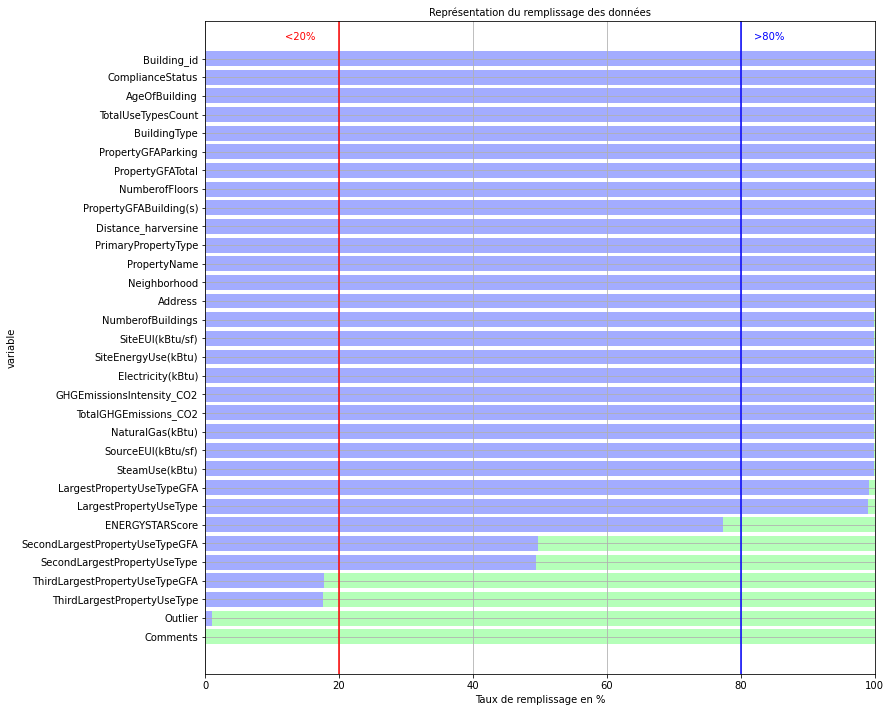

In [57]:
# Fonction pour afficher le ratio de données disponibles dans le dataset bâtiment
affich_taux_dispo (df_bat_data_dispo, 12, 12)

#### 4.5.1 Traitements des variables quantitatives

Dans le cadre de nos modélisations, les variables à prédire sont la consommation d'énergie du bâtiment (SiteEnergyUse(kBtu)) et ses émissions de CO2 (TotalGHGEmissions_CO2).

Traitements sur les variables quantitatives:
- on remarque que les variables relevés (variables avec le suffixe "kBtu" ou "_CO2") comportent très peu de valeurs NaN (1 seule valeur manquante par variable). Les lignes comportant de relevés sur ces variables avec des valeurs NaN sont supprimées.


- vérification si la présence ou non de valeurs manquantes dans les surfaces indiquées dans les variables "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA" et "ThirdLargestPropertyUseTypeGFA" et si elles sont bien renseignées et sont en cohérence avec le nombre de types d'usage du bâtiment dans la variable "TotalUseTypesCount":
     * si le nombre total d'usage du bâtiment = 1, les variables "SecondLargestPropertyUseTypeGFA" et "ThirdLargestPropertyUseTypeGFA" prennent la valeur 0 si présence NaN et la variable ""LargestPropertyUseTypeGFA" prend la valeur "PropertyGFATotal" si Nan.
     * si le nombre total d'usage du bâtiment = 2, la variable "ThirdLargestPropertyUseTypeGFA" prend la valeur 0 si présence NaN.
     * si le nombre total d'usage du bâtiment est >= 3, et si la variable "SecondLargestPropertyUseTypeGFA" ou "ThirdLargestPropertyUseTypeGFA" avec présence NaN, les variables "SecondLargestPropertyUseTypeGFA" et "ThirdLargestPropertyUseTypeGFA" prennent la valeur 0 et la variable ""LargestPropertyUseTypeGFA" prend la valeur "PropertyGFATotal". 
     
     
- imputation médiane pour la variable "ENERGYSTARScore" afin que cette variable soit comparée aux prédictions  

In [58]:
# Sélection des colonnes numériques dans le dataset des bâtiments
col_num = ['number']
df_data_bat_uniq_num = df_data_bat_uniq.select_dtypes(include=col_num)
df_data_bat_uniq_num.columns

Index(['Building_id', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions_CO2',
       'GHGEmissionsIntensity_CO2', 'TotalUseTypesCount', 'AgeOfBuilding',
       'Distance_harversine'],
      dtype='object')

In [59]:
# Suppression des lignes contenant des valeurs NaN pour les variables avec suffixe "kBtu" ou "_CO2"
print('------ Suppression des lignes contenant des valeurs NaN pour les variables avec suffixe "kBtu" ou "_CO2" ------')
df_in_suffix_kbtu_co2 = df_data_bat_uniq.iloc[:, df_data_bat_uniq.columns.str.contains('kBtu') | df_data_bat_uniq.columns.str.contains('_CO2')]
   
print('------ ' + 'Liste des colonnes:' + ' ------')
print(df_in_suffix_kbtu_co2.columns)
   
for col in df_in_suffix_kbtu_co2.columns:
    df_data_bat_uniq.dropna(subset=[col], axis=0, inplace=True)
    print('Suppression NaN pour la colonne ' + col)
    
print('------ Dataset suite suppression des lignes pour les variables avec suffixe "kBtu" ou "_CO2" ------')
print_proportion_nan(df_data_bat_uniq)

------ Suppression des lignes contenant des valeurs NaN pour les variables avec suffixe "kBtu" ou "_CO2" ------
------ Liste des colonnes: ------
Index(['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions_CO2', 'GHGEmissionsIntensity_CO2'],
      dtype='object')
Suppression NaN pour la colonne SiteEUI(kBtu/sf)
Suppression NaN pour la colonne SourceEUI(kBtu/sf)
Suppression NaN pour la colonne SiteEnergyUse(kBtu)
Suppression NaN pour la colonne SteamUse(kBtu)
Suppression NaN pour la colonne Electricity(kBtu)
Suppression NaN pour la colonne NaturalGas(kBtu)
Suppression NaN pour la colonne TotalGHGEmissions_CO2
Suppression NaN pour la colonne GHGEmissionsIntensity_CO2
------ Dataset suite suppression des lignes pour les variables avec suffixe "kBtu" ou "_CO2" ------
Proportion de NaN : 15.27 %, Taille du jeu de données : (3428, 32)



In [60]:
# Appel fonction pour le traitement des valeurs Nan des variables 'LargestPropertyUseTypeGFA',
# 'SecondLargestPropertyUseTypeGFA' et 'ThirdLargestPropertyUseTypeGFA' ligne par ligne 
df_data_bat_nan = traite_nan_propertyuse_gfa(df_data_bat_uniq, 'TotalUseTypesCount', 'LargestPropertyUseTypeGFA',
                                             'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
                                             'PropertyGFATotal')
    
print('------ Dataset suite remplacement des valeurs NaN sur les variables type GFA ------')
print_proportion_nan(df_data_bat_nan)

------ Dataset suite remplacement des valeurs NaN sur les variables type GFA ------
Proportion de NaN : 11.11 %, Taille du jeu de données : (3428, 32)



In [61]:
# Imputation valeurs manquantes - variable EnergyStar
df_data_bat_nan = traite_nan_imputation_median(df_data_bat_nan, 'ENERGYSTARScore')

------ Jeu de données suite imputation knn pour variable ENERGYSTARScore ------
Proportion de NaN : 10.4 %, Taille du jeu de données : (3428, 32)



#### 4.5.2 Traitements des variables qualitatives

Traitements sur les variables qualitatives:
- pour les variables "LargestPropertyUseType","SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", on impute la valeur 'Other' si présence de valeurs NaN.


- la variable "Comments" est supprimée car elle contient uniquement des valeurs NaN.


- suppression des bâtiments non conformes (avec valeur différent de 'Compliant' dans la variable "ComplianceStatus") et suppression de la variable "ComplianceStatus".


- suppression de la variable "Outlier".

In [62]:
# Sélection des colonnes qualitatives dans le dataset des bâtiments
col_obj = ['object']
df_data_bat_nan_obj = df_data_bat_nan.select_dtypes(include=col_obj)
df_data_bat_nan_obj.columns

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address',
       'Neighborhood', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'Comments', 'ComplianceStatus', 'Outlier'],
      dtype='object')

In [63]:
# Affichage des différents statuts de conformité des données
df_data_bat_nan['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [64]:
# Affichage du nombre de bâtiments non conformes
print("Nombre de ligne identifiées comme non conforme : {}.".format(df_data_bat_nan[df_data_bat_nan['ComplianceStatus'] != "Compliant"].shape[0]))

Nombre de ligne identifiées comme non conforme : 163.


In [65]:
# Prise en compte des bâtiments avec le statut "Compliant" (conforme)
df_data_bat_nan = df_data_bat_nan[df_data_bat_nan['ComplianceStatus'] == "Compliant"]

print('------ Jeu de données suite au traitement des valeurs NaN des variables numériques -----')
print_proportion_nan(df_data_bat_nan)

------ Jeu de données suite au traitement des valeurs NaN des variables numériques -----
Proportion de NaN : 10.37 %, Taille du jeu de données : (3265, 32)



In [66]:
# Affectation des listes des colonnes à supprimer, à imputer
liste_col_a_supprimer = ['Comments', 'ComplianceStatus']
liste_col_a_imputer = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

# Appel de la fonction pour le traitement des valeurs manquantes pour les variables qualitatives
df_data_bat_nan = traite_nan_obj(df_data_bat_nan, liste_col_a_supprimer, liste_col_a_imputer, val_imput='Other')

Imputation valeur Other pour remplacer NaN pour la colonne LargestPropertyUseType
Imputation valeur Other pour remplacer NaN pour la colonne SecondLargestPropertyUseType
Imputation valeur Other pour remplacer NaN pour la colonne ThirdLargestPropertyUseType

------ Dataset suite imputation de la valeur Other sur les colonnes ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'] ------
Proportion de NaN : 6.25 %, Taille du jeu de données : (3265, 32)


------ Dataset suite suppression sur les colonnes ['Comments', 'ComplianceStatus'] ------
Proportion de NaN : 3.33 %, Taille du jeu de données : (3265, 30)



In [67]:
# Affichage des différents statuts de la colonne "Outlier"
df_data_bat_nan['Outlier'].unique()

array([nan, 'Low Outlier'], dtype=object)

In [68]:
# Suppression des bâtiments avec le statut 'Low Outlier' et suppression de la variable "Outlier"
df_data_bat_nan = df_data_bat_nan[~df_data_bat_nan["Outlier"].isnull()==False]
df_data_bat_nan.drop('Outlier', axis=1, inplace=True)

print('')
print('------- Dataset suite suppression colonne "Outlier"')
print_proportion_nan(df_data_bat_nan)


------- Dataset suite suppression colonne "Outlier"
Proportion de NaN : 0.0 %, Taille du jeu de données : (3262, 29)



In [69]:
# Appel de la fonction pour construire la dataframe récapitulant les données disponibles dans le dataset des bâtiments
df_bat_data_dispo = desc_data_dispo(df_data_bat_nan)
df_bat_data_dispo

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
nbre valeurs manquantes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nbre de valeurs dispo.,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262,3262
taux remplissage,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100


In [70]:
df_data_bat_nan

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,61,1.0,4.0,48383.0,0.0,48383.0,38172.0,10211.0,0.0,61.000000,129.600000,2.953338e+06,915977.0,1.448859e+06,5.885630e+05,112.06,2.19,2,115,0.456414,75.0,Multifamily LR (1-4),Low-Rise Multifamily,GATEWOOD APTS,107 PINE ST,DOWNTOWN,Multifamily Housing,Retail Store,Other
1,266,1.0,4.0,52134.0,0.0,52134.0,52134.0,0.0,0.0,23.300000,73.000000,1.212551e+06,0.0,1.212601e+06,0.000000e+00,8.45,0.06,1,8,4.745164,85.0,Multifamily LR (1-4),Low-Rise Multifamily,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE,Multifamily Housing,Other,Other
2,325,1.0,4.0,111077.0,0.0,111077.0,111077.0,0.0,0.0,60.600000,190.200000,9.898724e+06,0.0,9.899135e+06,0.000000e+00,69.01,0.24,1,26,0.439292,91.0,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN,Other,Other,Other
3,400,1.0,6.0,98370.0,25920.0,72450.0,98370.0,0.0,0.0,66.300000,207.500000,6.525887e+06,0.0,6.488262e+06,3.789300e+04,47.24,0.20,1,109,0.236408,45.0,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN,Office,Other,Other
4,442,1.0,4.0,193788.0,37854.0,155934.0,138672.0,47539.0,11166.0,105.800000,332.300000,1.676022e+07,0.0,1.676091e+07,0.000000e+00,116.84,0.23,5,68,1.171413,59.0,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION,Office,Parking,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3426,50221,1.0,1.0,18261.0,0.0,18261.0,18261.0,0.0,0.0,51.000000,126.000000,9.320821e+05,0.0,6.323620e+05,2.997200e+05,20.33,1.11,1,34,4.935141,68.0,Nonresidential COS,Other,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS,Other - Recreation,Other,Other
3428,50223,1.0,1.0,16000.0,0.0,16000.0,16000.0,0.0,0.0,59.400002,114.199997,9.502762e+05,0.0,3.965461e+05,5.537300e+05,32.17,2.01,1,12,0.811312,68.0,Nonresidential COS,Other,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN,Other - Recreation,Other,Other
3429,50224,1.0,1.0,13157.0,0.0,13157.0,7583.0,5574.0,0.0,438.200012,744.799988,5.765898e+06,0.0,1.792159e+06,3.973739e+06,223.54,16.99,3,42,2.407156,68.0,Nonresidential COS,Other,QUEEN ANNE POOL,1920 1ST AVE W,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool
3430,50225,1.0,1.0,14101.0,0.0,14101.0,6601.0,6501.0,484.0,51.000000,105.300003,7.194712e+05,0.0,3.488702e+05,3.706010e+05,22.11,1.57,5,27,5.389475,68.0,Nonresidential COS,Mixed Use Property,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare


### 4.4 Traitement des outliers

In [71]:
# Appel de la fonction qui affiche un récapitulatif des outliers pour les variables quantitatives 
# sous forme d'un tableau
df_recap_outlier = desc_outliers(df_data_bat_nan)
df_recap_outlier

 ------ Traitement de outliers: liste des colonnes quantitatives à traiter ------
Index(['Building_id', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions_CO2',
       'GHGEmissionsIntensity_CO2', 'TotalUseTypesCount', 'AgeOfBuilding',
       'Distance_harversine', 'EnergyStar'],
      dtype='object')



,Min,Max,Nbre > 0,Nbre < 0
Building_id,1,50226,3262,0
NumberofBuildings,0.5,111,3262,0
NumberofFloors,0,99,3262,0
PropertyGFATotal,11285,9.32016e+06,3262,0
PropertyGFAParking,-1.5,512608,3260,2
PropertyGFABuilding(s),-8451,9.32016e+06,3261,1
LargestPropertyUseTypeGFA,6455,9.32016e+06,3262,0
SecondLargestPropertyUseTypeGFA,0,639931,3262,0
ThirdLargestPropertyUseTypeGFA,0,459748,3262,0
SiteEUI(kBtu/sf),1.35,834.4,3262,0


Traitement des outliers:
- suppression des valeurs négatives pour la variable "PropertyGFAParking"
- suppression des valeurs négatives pour la variable "PropertyGFABuilding(s)"

In [72]:
df_data_bat_nan.drop(df_data_bat_nan.loc[df_data_bat_nan['PropertyGFAParking']<0].index, inplace=True)
df_data_bat_nan.drop(df_data_bat_nan.loc[df_data_bat_nan['PropertyGFABuilding(s)']<0].index, inplace=True)

print('------- Dataset suite traitement des outliers - variables \"PropertyGFAParking\" et \"PropertyGFABuilding(s)\"')
print_proportion_nan(df_data_bat_nan)

df_data_bat_final = df_data_bat_nan.copy()

------- Dataset suite traitement des outliers - variables "PropertyGFAParking" et "PropertyGFABuilding(s)"
Proportion de NaN : 0.0 %, Taille du jeu de données : (3259, 29)



### 4.5 Récapitulatif du dataset après traitement des valeurs manquantes et des outliers

In [73]:
df_data_bat_final

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,61,1.0,4.0,48383.0,0.0,48383.0,38172.0,10211.0,0.0,61.000000,129.600000,2.953338e+06,915977.0,1.448859e+06,5.885630e+05,112.06,2.19,2,115,0.456414,75.0,Multifamily LR (1-4),Low-Rise Multifamily,GATEWOOD APTS,107 PINE ST,DOWNTOWN,Multifamily Housing,Retail Store,Other
1,266,1.0,4.0,52134.0,0.0,52134.0,52134.0,0.0,0.0,23.300000,73.000000,1.212551e+06,0.0,1.212601e+06,0.000000e+00,8.45,0.06,1,8,4.745164,85.0,Multifamily LR (1-4),Low-Rise Multifamily,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE,Multifamily Housing,Other,Other
2,325,1.0,4.0,111077.0,0.0,111077.0,111077.0,0.0,0.0,60.600000,190.200000,9.898724e+06,0.0,9.899135e+06,0.000000e+00,69.01,0.24,1,26,0.439292,91.0,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN,Other,Other,Other
3,400,1.0,6.0,98370.0,25920.0,72450.0,98370.0,0.0,0.0,66.300000,207.500000,6.525887e+06,0.0,6.488262e+06,3.789300e+04,47.24,0.20,1,109,0.236408,45.0,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN,Office,Other,Other
4,442,1.0,4.0,193788.0,37854.0,155934.0,138672.0,47539.0,11166.0,105.800000,332.300000,1.676022e+07,0.0,1.676091e+07,0.000000e+00,116.84,0.23,5,68,1.171413,59.0,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION,Office,Parking,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3426,50221,1.0,1.0,18261.0,0.0,18261.0,18261.0,0.0,0.0,51.000000,126.000000,9.320821e+05,0.0,6.323620e+05,2.997200e+05,20.33,1.11,1,34,4.935141,68.0,Nonresidential COS,Other,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS,Other - Recreation,Other,Other
3428,50223,1.0,1.0,16000.0,0.0,16000.0,16000.0,0.0,0.0,59.400002,114.199997,9.502762e+05,0.0,3.965461e+05,5.537300e+05,32.17,2.01,1,12,0.811312,68.0,Nonresidential COS,Other,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN,Other - Recreation,Other,Other
3429,50224,1.0,1.0,13157.0,0.0,13157.0,7583.0,5574.0,0.0,438.200012,744.799988,5.765898e+06,0.0,1.792159e+06,3.973739e+06,223.54,16.99,3,42,2.407156,68.0,Nonresidential COS,Other,QUEEN ANNE POOL,1920 1ST AVE W,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool
3430,50225,1.0,1.0,14101.0,0.0,14101.0,6601.0,6501.0,484.0,51.000000,105.300003,7.194712e+05,0.0,3.488702e+05,3.706010e+05,22.11,1.57,5,27,5.389475,68.0,Nonresidential COS,Mixed Use Property,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare


In [74]:
df_data_bat_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3259 entries, 0 to 3431
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Building_id                      3259 non-null   int64  
 1   NumberofBuildings                3259 non-null   float64
 2   NumberofFloors                   3259 non-null   float64
 3   PropertyGFATotal                 3259 non-null   float64
 4   PropertyGFAParking               3259 non-null   float64
 5   PropertyGFABuilding(s)           3259 non-null   float64
 6   LargestPropertyUseTypeGFA        3259 non-null   float64
 7   SecondLargestPropertyUseTypeGFA  3259 non-null   float64
 8   ThirdLargestPropertyUseTypeGFA   3259 non-null   float64
 9   SiteEUI(kBtu/sf)                 3259 non-null   float64
 10  SourceEUI(kBtu/sf)               3259 non-null   float64
 11  SiteEnergyUse(kBtu)              3259 non-null   float64
 12  SteamUse(kBtu)      

In [75]:
# Appel de la fonction pour construire la dataframe récapitulant les données disponibles dans le dataset des bâtiments
df_bat_data_dispo = desc_data_dispo(df_data_bat_final)
df_bat_data_dispo

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
nbre valeurs manquantes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nbre de valeurs dispo.,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259
taux remplissage,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100


In [76]:
print_proportion_nan(df_data_bat_final)

Proportion de NaN : 0.0 %, Taille du jeu de données : (3259, 29)



Il n'y a plus de valeurs NaN et les valeurs aberrantes ont été écartées lors du traitement des outliers.

## 5. Analyse exploratoire des données

### 5.1 Analyse univariée des variables à prédire

Les variables "TotalGHGEmissions_CO2" et "SiteEnergyUse(kBtu)" sont les variables à prédire dans notre modélisation.

Ces variables vont être étudiées dans le cadre d'un analyse univariée.

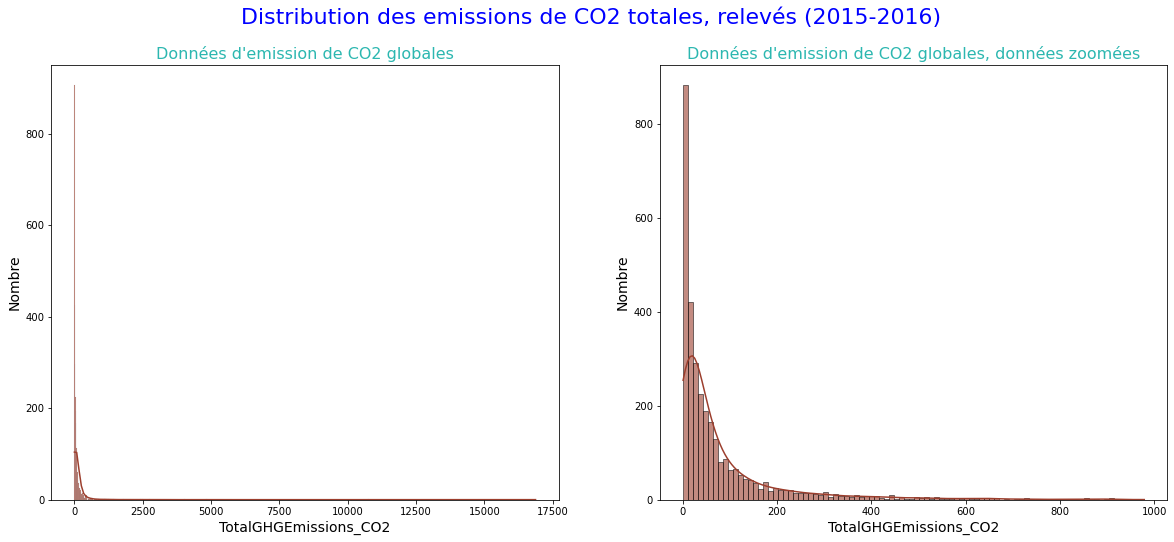

In [77]:
# Appel de la fonction pour l'affichage du diagramme de distribution (global / zoom) pour la variable "TotalGHGEmissions_CO2"
affich_diagramme_dist(df_data_bat_final,'TotalGHGEmissions_CO2',1000,'Données d\'emission de CO2 globales',\
                     'Données d\'emission de CO2 globales, données zoomées',\
                      'Distribution des emissions de CO2 totales, relevés (2015-2016)')

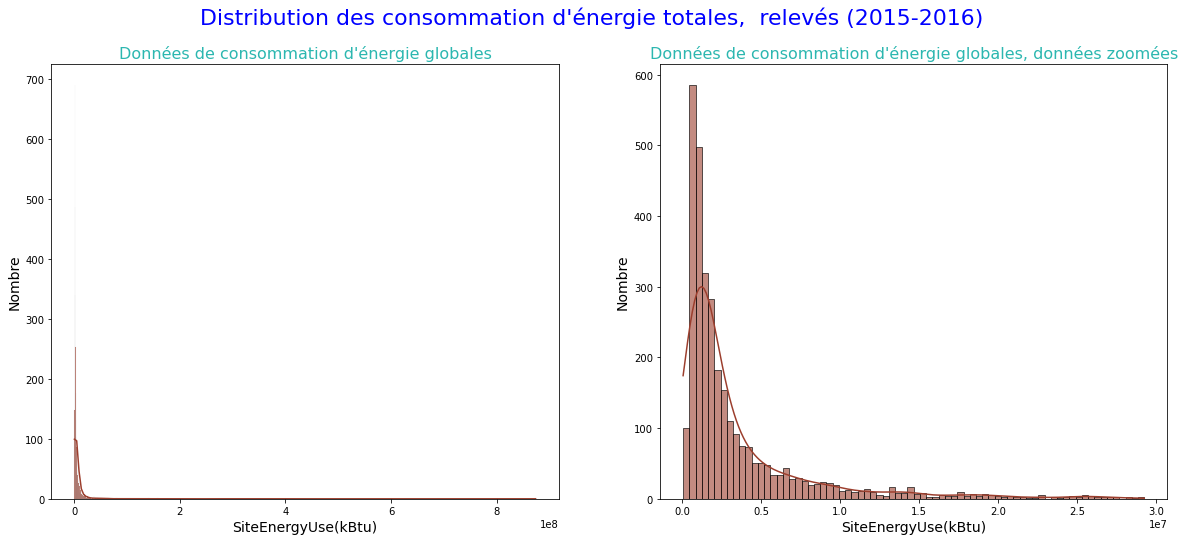

In [78]:
# Appel de la fonction pour l'affichage du diagramme de distribution pour la variable "SiteEnergyUse(kBtu)"
affich_diagramme_dist(df_data_bat_final, 'SiteEnergyUse(kBtu)', 0.3*10**8, 'Données de consommation d\'énergie globales',\
                     'Données de consommation d\'énergie globales, données zoomées',\
                      'Distribution des consommation d\'énergie totales,  relevés (2015-2016)')

#### 5.1.1 Impact du passage des variables à prédire à l'échelle logarithmique

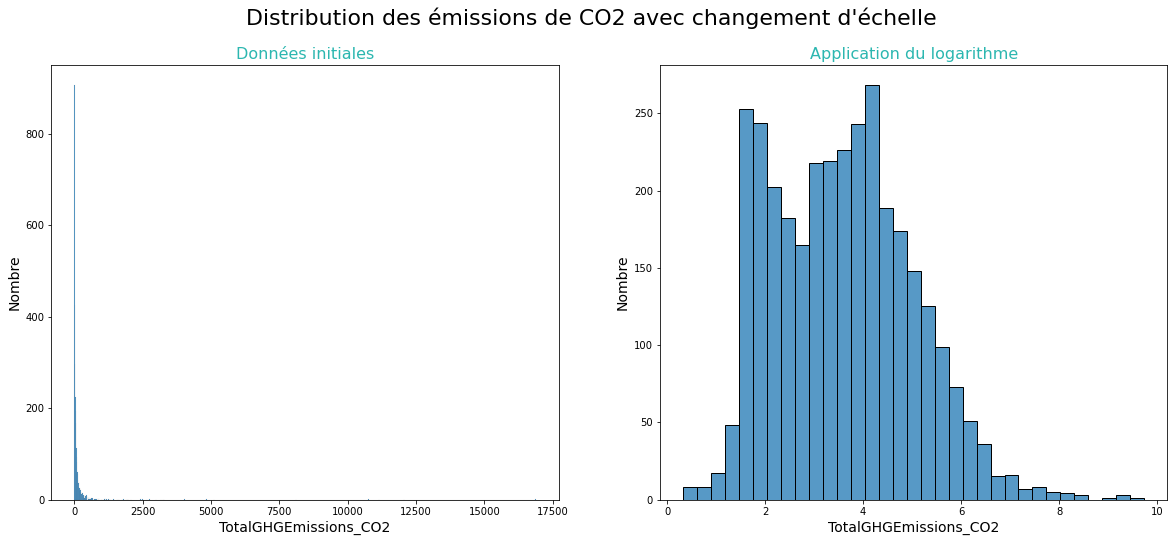

In [79]:
# Appel fonction affichage variable à l'échelle logarithmique - variable "TotalGHGEmissions_CO2"
logtransform_affich(df_data_bat_final, 'TotalGHGEmissions_CO2', 
                    'Distribution des émissions de CO2 avec changement d\'échelle')

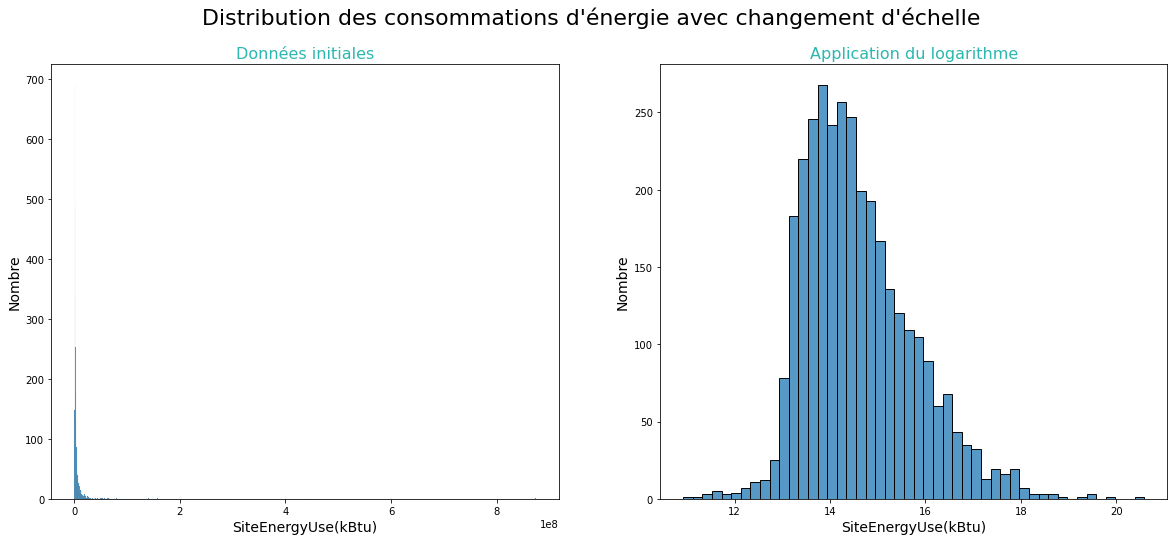

In [80]:
# Appel fonction affichage variable à l'échelle logarithmique - variable "SiteEnergyUse(kBtu)"
logtransform_affich(df_data_bat_final, 'SiteEnergyUse(kBtu)', 
                    'Distribution des consommations d\'énergie avec changement d\'échelle')

En passant les données des variables à prédire à l'échelle logarithmique, on obtient une distribution normale des données à prédire. Nous allons donc appliquer cette transformation dans le pipeline de pré-processing de traitement des données avant évaluation des modèles.

La fonction inverse (exp) sera donc passée pour les prédictions.

#### 5.1.2 Affichage des boxplots

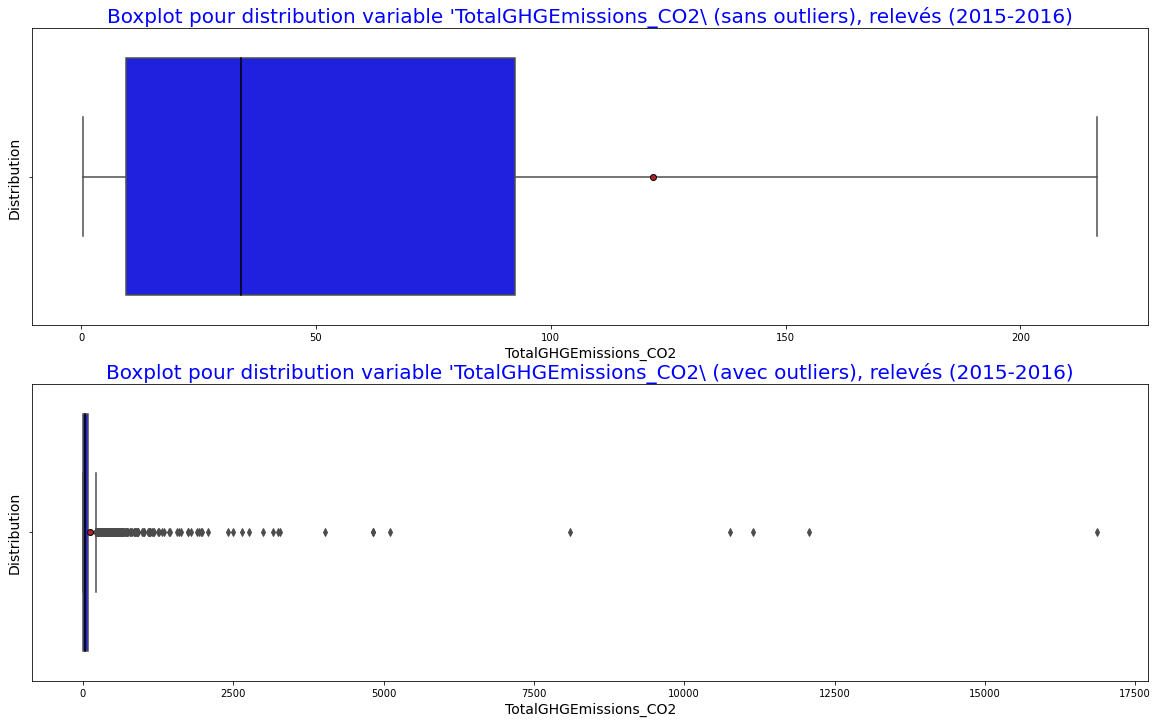

In [81]:
# Appel de la fonction pour l'affichage du boxplot pour la variable "TotalGHGEmissions_CO2"
affich_boxplot(df_data_bat_final,'TotalGHGEmissions_CO2',\
               'Boxplot pour distribution variable \'TotalGHGEmissions_CO2\ (sans outliers), relevés (2015-2016)',\
               'Boxplot pour distribution variable \'TotalGHGEmissions_CO2\ (avec outliers), relevés (2015-2016)')

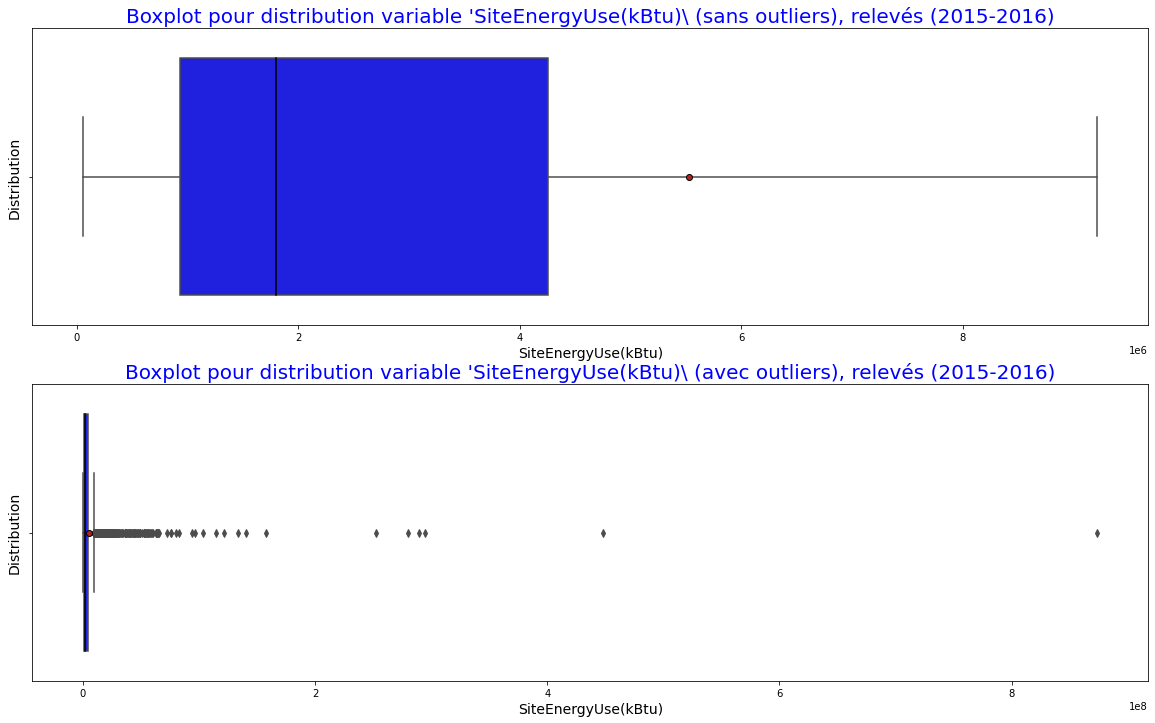

In [82]:
# Appel de la fonction pour l'affichage du boxplot pour la variable "SiteEnergyUse(kBtu)"
affich_boxplot(df_data_bat_final,'SiteEnergyUse(kBtu)',\
               'Boxplot pour distribution variable \'SiteEnergyUse(kBtu)\ (sans outliers), relevés (2015-2016)',
               'Boxplot pour distribution variable \'SiteEnergyUse(kBtu)\ (avec outliers), relevés (2015-2016)')

On remarque la, présence d'outliers pour les variables "TotalGHGEmissions_CO2" et "SiteEnergyUse(kBtu)". On vérifie que les valeurs sont bien des valeurs atypiques par aux données source de 2015 et 2016.

On va vérifier les bâtiments pour lesquels la valeur de la variable "TotalGHGEmissions_CO2" est supérieure à 4000 sur les relevés 2015 et 2016.
 
On va vérifier les bâtiments pour lesquels la valeur de la variable "SiteEnergyUse(kBtu)" est supérieure à 2e+08 sur les relevés 2015 et 2016.


In [83]:
# Vérification outliers sur la variable "TotalGHGEmissions_CO2" - valeurs supérieure à 4000 (relevés 2015)
df_bat_2015[df_bat_2015['TotalGHGEmissions_CO2']>4000].sort_values(by='TotalGHGEmissions_CO2', ascending=False)

,Building_id,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
621,828,2015,NonResidential,Hospital,SWEDISH HOSPITAL MEDICAL CENTER First Hill Campus,1978201096,3,EAST,1994,1,14.0,1765970,0,1765970,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1639334.0,Parking,441551.0,NaN,NaN,NaN,59.0,174.9,178.6,374.6,372.0,286685536.0,292746272.0,127869744.0,41161340.0,140448322.0,183733.0,18373320.0,11824.89,6.35,No,NaN,Compliant,NaN,47.608951,-122.322402,747 BROADWAY,SEATTLE,WA,98122
170,276,2015,NonResidential,Hospital,HARBORVIEW MEDICAL CENTER,8590900220,3,EAST,2000,1,8.0,1158691,0,1158691,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1350182.0,Parking,387651.0,NaN,NaN,NaN,30.0,219.1,220.5,508.5,498.3,295812640.0,297740960.0,122701720.0,50083380.0,170891586.0,22264.0,2226424.0,10780.64,8.67,No,NaN,Compliant,NaN,47.60387131,-122.3226998,325 9TH AVE,SEATTLE,WA,98104
123,198,2015,NonResidential,Hospital,SEATTLE CHILDREN'S HOSPITAL (MAIN CAMPUS),2982800005,4,NORTHEAST,1953,1,10.0,879000,0,879000,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),879000.0,NaN,NaN,NaN,NaN,NaN,13.0,285.8,290.9,572.9,561.7,251191824.0,255669168.0,0.0,33629360.0,114748139.0,1364484.0,136448438.0,8046.70,8.59,No,NaN,Compliant,NaN,47.66356652,-122.2813832,4800 SAND POINT WAY NE,SEATTLE,WA,98105
3272,49859,2015,Campus,Other,AMGEN INC. MASTER CAMPUS,7666201725,7,MAGNOLIA / QUEEN ANNE,2002,7,4.0,808520,376000,432520,Other,Other,808520.0,NaN,NaN,NaN,NaN,NaN,NaN,194.9,206.0,403.0,414.6,157606480.0,166523440.0,0.0,22490860.0,76742000.0,808676.0,80867644.0,4829.86,5.57,No,NaN,Compliant,NaN,47.62811223,-122.3742647,1201 AMGEN CT W,SEATTLE,WA,98119
167,268,2015,NonResidential,Hospital,SWEDISH MEDICAL CENTER CHERRY HILL CAMPUS,7942600331,3,CENTRAL,1990,1,5.0,597519,0,597519,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),601615.0,Parking,48607.0,NaN,NaN,NaN,45.0,228.8,236.9,434.8,434.9,137635696.0,142494256.0,0.0,16416700.0,56016106.0,816219.0,81621919.0,4725.43,7.51,No,NaN,Compliant,NaN,47.60710663,-122.3107827,500 17TH AVE,SEATTLE,WA,98122
341,477,2015,Campus,Other,FHCRC - Weintraub/Hutchinson/Thomas Bldgs Campus,1984200455,3,LAKE UNION,1997,3,5.0,535947,195283,340664,"Other, Parking",Other,535947.0,Parking,103983.0,NaN,NaN,NaN,NaN,254.2,272.9,536.6,546.4,136241424.0,146248640.0,0.0,20265210.0,69147767.0,670965.0,67096519.0,4045.53,6.99,No,NaN,Compliant,NaN,47.6286355,-122.3306365,1100 FAIRVIEW AVE N,SEATTLE,WA,98109


In [84]:
# Vérification outliers sur la variable "TotalGHGEmissions_CO2" - valeurs supérieure à 4000 (relevés 2016)
df_bat_2016[df_bat_2016['TotalGHGEmissions_CO2']>4000].sort_values(by='TotalGHGEmissions_CO2', ascending=False)

,Building_id,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2
35,43,2016,Campus,Mixed Use Property,Plant 2 Site,7755 E MARGINAL WAY S,Seattle,WA,98108.0,0022000005,2,GREATER DUWAMISH,47.534930,-122.317880,1992,1.0,3,494835,0,494835,"Energy/Power Station, Laboratory, Manufacturing/Industrial Plant, Non-Refrigerated Warehouse, Office",Office,757027.0,Laboratory,639931.0,Non-Refrigerated Warehouse,459748.0,NaN,8.0,221.699997,233.100006,388.200012,400.299988,448385312.0,471613856.0,0.0,44102076.0,150476283.0,2.979090e+06,297909000.0,False,NaN,Compliant,NaN,16870.98,34.09
618,828,2016,NonResidential,Hospital,Swedish First Hill,747 Broadway,Seattle,WA,98122.0,1978201096,3,EAST,47.608951,-122.322402,1994,7.0,14,1765970,0,1765970,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1639334.0,Parking,441551.0,NaN,NaN,NaN,54.0,177.899994,180.500000,377.000000,378.399994,291614432.0,295929888.0,134943456.0,40842564.0,139354828.0,1.731612e+05,17316120.0,False,NaN,Compliant,NaN,12307.16,6.97
3274,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,Seattle,WA,98105.0,1625049001,4,NORTHEAST,47.656440,-122.310410,1900,111.0,0,9320156,0,9320156,College/University,College/University,9320156.0,NaN,NaN,NaN,NaN,NaN,NaN,93.800003,0.000000,246.600006,0.000000,873923712.0,0.0,84985240.0,192577488.0,657074389.0,0.000000e+00,0.0,False,NaN,Compliant,NaN,11140.56,1.20
170,276,2016,NonResidential,Hospital,Harborview Medical Center,325 9th Ave.,Seattle,WA,98104.0,8590900220,3,EAST,47.603990,-122.323770,2000,9.0,8,1158691,0,1158691,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1350182.0,Parking,387651.0,NaN,NaN,NaN,29.0,217.100006,219.699997,502.899994,502.799988,293090784.0,296671744.0,122575032.0,49438336.0,168683602.0,1.832129e+04,1832129.0,False,NaN,Compliant,NaN,10734.57,9.26
124,198,2016,NonResidential,Hospital,Seattle Children's Hospital Main Campus,4800 Sand Point Way NE,Seattle,WA,98105.0,2982800005,4,NORTHEAST,47.662310,-122.281460,1953,6.0,10,879000,0,879000,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),879000.0,NaN,NaN,NaN,NaN,NaN,10.0,288.799988,293.200012,578.200012,576.599976,253832464.0,257764208.0,0.0,33892500.0,115641210.0,1.381912e+06,138191238.0,False,NaN,Compliant,NaN,8145.52,9.27
3264,49940,2016,NonResidential,Hospital,Virginia Mason Medical Center - 2149,925 Seneca St.,Seattle,WA,98101.0,1979200210,3,EAST,47.609860,-122.327740,1920,1.0,8,374466,0,374466,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),1010135.0,NaN,NaN,NaN,NaN,NaN,74.0,162.300003,165.500000,367.899994,369.399994,163945984.0,167207104.0,73885472.0,26395222.0,90060497.0,0.000000e+00,0.0,False,NaN,Compliant,NaN,6330.91,16.91
167,268,2016,NonResidential,Hospital,Swedish Cherry Hill,500 17th Ave,Seattle,WA,98122.0,7942600331,3,CENTRAL,47.607050,-122.309660,1990,6.0,5,597519,0,597519,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),601615.0,Parking,48607.0,NaN,NaN,NaN,34.0,238.399994,244.800003,454.399994,459.200012,143423024.0,147299056.0,0.0,17220084.0,58754927.0,8.466809e+05,84668094.0,False,NaN,Compliant,NaN,4906.33,8.21


Pour la variable "TotalGHGEmissions_CO2", la valeur la plus élevée (16870.98) correspond à un bâtiment utilisé comme laboratoire et station d'énergie sur un campus universitaire, d'où un bilan carbone élevé, ce qui semble logique.

Pour les autres valeurs les plus élevées, cela correspond à des hôpitaux, la présence de climatisations, de générateurs électriques peuvent expliquer un bilan carbone élevé.

Par conséquent, nous considérons ces valeurs comme atypiques, elles sont conservées.

In [85]:
# Vérification outliers sur la variable "SiteEnergyUse(kBtu)" - valeurs supérieure à 2e+08 (relevés 2015)
df_bat_2015[df_bat_2015['SiteEnergyUse(kBtu)']>2*10**8].sort_values(by='SiteEnergyUse(kBtu)', ascending=False)

,Building_id,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
170,276,2015,NonResidential,Hospital,HARBORVIEW MEDICAL CENTER,8590900220,3,EAST,2000,1,8.0,1158691,0,1158691,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1350182.0,Parking,387651.0,NaN,NaN,NaN,30.0,219.1,220.5,508.5,498.3,295812640.0,297740960.0,122701720.0,50083380.0,170891586.0,22264.0,2226424.0,10780.64,8.67,No,NaN,Compliant,NaN,47.60387131,-122.3226998,325 9TH AVE,SEATTLE,WA,98104
621,828,2015,NonResidential,Hospital,SWEDISH HOSPITAL MEDICAL CENTER First Hill Campus,1978201096,3,EAST,1994,1,14.0,1765970,0,1765970,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1639334.0,Parking,441551.0,NaN,NaN,NaN,59.0,174.9,178.6,374.6,372.0,286685536.0,292746272.0,127869744.0,41161340.0,140448322.0,183733.0,18373320.0,11824.89,6.35,No,NaN,Compliant,NaN,47.608951,-122.322402,747 BROADWAY,SEATTLE,WA,98122
560,753,2015,NonResidential,Other,THE WESTIN BUILDING,659000950,7,DOWNTOWN,1981,1,33.0,429405,0,429405,"Data Center, Office",Data Center,218997.0,Office,210409.0,NaN,NaN,NaN,71.0,663.4,663.4,2082.3,2082.3,284867168.0,284867168.0,0.0,83445048.0,284726322.0,1526.0,152639.0,1992.96,1.79,No,NaN,Compliant,NaN,47.61435318,-122.33885956,2001 6TH AVE,SEATTLE,WA,98121
123,198,2015,NonResidential,Hospital,SEATTLE CHILDREN'S HOSPITAL (MAIN CAMPUS),2982800005,4,NORTHEAST,1953,1,10.0,879000,0,879000,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),879000.0,NaN,NaN,NaN,NaN,NaN,13.0,285.8,290.9,572.9,561.7,251191824.0,255669168.0,0.0,33629360.0,114748139.0,1364484.0,136448438.0,8046.70,8.59,No,NaN,Compliant,NaN,47.66356652,-122.2813832,4800 SAND POINT WAY NE,SEATTLE,WA,98105


In [86]:
# Vérification outliers sur la variable "SiteEnergyUse(kBtu)" - valeurs supérieure à 2e+08 (relevés 2016)
df_bat_2016[df_bat_2016['SiteEnergyUse(kBtu)']>2*10**8].sort_values(by='SiteEnergyUse(kBtu)', ascending=False)

,Building_id,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2
3274,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,Seattle,WA,98105.0,1625049001,4,NORTHEAST,47.656440,-122.310410,1900,111.0,0,9320156,0,9320156,College/University,College/University,9320156.0,NaN,NaN,NaN,NaN,NaN,NaN,93.800003,0.000000,246.600006,0.000000,873923712.0,0.0,84985240.0,192577488.0,657074389.0,0.000000e+00,0.0,False,NaN,Compliant,NaN,11140.56,1.20
35,43,2016,Campus,Mixed Use Property,Plant 2 Site,7755 E MARGINAL WAY S,Seattle,WA,98108.0,0022000005,2,GREATER DUWAMISH,47.534930,-122.317880,1992,1.0,3,494835,0,494835,"Energy/Power Station, Laboratory, Manufacturing/Industrial Plant, Non-Refrigerated Warehouse, Office",Office,757027.0,Laboratory,639931.0,Non-Refrigerated Warehouse,459748.0,NaN,8.0,221.699997,233.100006,388.200012,400.299988,448385312.0,471613856.0,0.0,44102076.0,150476283.0,2.979090e+06,297909000.0,False,NaN,Compliant,NaN,16870.98,34.09
170,276,2016,NonResidential,Hospital,Harborview Medical Center,325 9th Ave.,Seattle,WA,98104.0,8590900220,3,EAST,47.603990,-122.323770,2000,9.0,8,1158691,0,1158691,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1350182.0,Parking,387651.0,NaN,NaN,NaN,29.0,217.100006,219.699997,502.899994,502.799988,293090784.0,296671744.0,122575032.0,49438336.0,168683602.0,1.832129e+04,1832129.0,False,NaN,Compliant,NaN,10734.57,9.26
618,828,2016,NonResidential,Hospital,Swedish First Hill,747 Broadway,Seattle,WA,98122.0,1978201096,3,EAST,47.608951,-122.322402,1994,7.0,14,1765970,0,1765970,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1639334.0,Parking,441551.0,NaN,NaN,NaN,54.0,177.899994,180.500000,377.000000,378.399994,291614432.0,295929888.0,134943456.0,40842564.0,139354828.0,1.731612e+05,17316120.0,False,NaN,Compliant,NaN,12307.16,6.97
558,753,2016,NonResidential,Other,WestinBuilding,2001 6th Ave,Seattle,WA,98121.0,0659000950,7,DOWNTOWN,47.614380,-122.338710,1981,1.0,33,429405,0,429405,"Data Center, Office",Data Center,218997.0,Office,210409.0,NaN,NaN,NaN,98.0,639.700012,639.799988,2007.900024,2008.000000,274682208.0,274725984.0,0.0,80460872.0,274532495.0,1.496720e+03,149672.0,False,NaN,Compliant,NaN,1921.82,4.48
124,198,2016,NonResidential,Hospital,Seattle Children's Hospital Main Campus,4800 Sand Point Way NE,Seattle,WA,98105.0,2982800005,4,NORTHEAST,47.662310,-122.281460,1953,6.0,10,879000,0,879000,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),879000.0,NaN,NaN,NaN,NaN,NaN,10.0,288.799988,293.200012,578.200012,576.599976,253832464.0,257764208.0,0.0,33892500.0,115641210.0,1.381912e+06,138191238.0,False,NaN,Compliant,NaN,8145.52,9.27


Pour la variable "SiteEnergyUse(kBtu)", la valeur la plus élevée (873923712) correspond à un bâtiment construit en 1900, sans doute peu rénové et pas du tout aux normes environnementales des bâtiments actuels. Par ailleurs, le site correspond à l'université de Seattle et comporte 111 bâtiments, avec une surface au sol très importante, ce qui peut expliquer les chiffre très elevé de la consommation totale d'énergie.

Pour les autres valeurs les plus élevées, cela correspond à des hôpitaux, très consommateurs en énergie, notamment électrique (présence de climatisations, de générateurs électriques, de matériels chirurgicaux,...).

Par conséquent, nous considérons ces valeurs comme atypiques, elles sont conservées. 

### 5.2 Analyse univariée des variables qualitatives

#### 5.2.1  Répartition des types de bâtiment

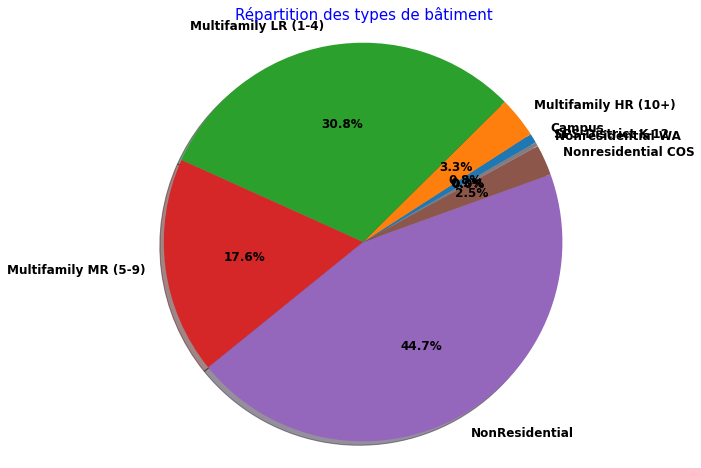

In [87]:
# Affichage de la répartition des types de bâtiment
type_bat = df_data_bat_final.groupby(by='BuildingType')['Building_id'].nunique()

font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 26,
             }

fig = plt.figure(figsize=(8,8))
pie = plt.pie(type_bat.values, labels=type_bat.index, 
       autopct='%1.1f%%', shadow=True, startangle=30,
       textprops=dict(color="black",size=12, weight="bold"))
plt.axis('equal')
plt.title("Répartition des types de bâtiment", fontsize=15, color="blue")
plt.show()

La majeure partie des bâtiments sont typés "NonResidential". Nous pouvons visualiser les diverses catégories représentées dans ce type de bâtiments.

#### 5.2.2 Répartition des catégories de bâtiment non résidentiels

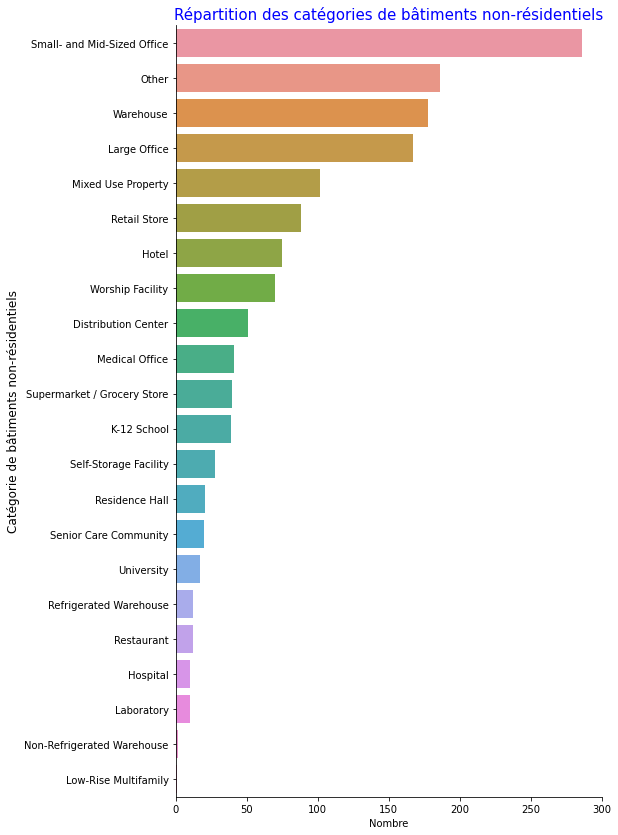

In [88]:
# Affichage des catégories de bâtiments non-résidentiels
categ_nonresid = df_data_bat_final[(df_data_bat_final['BuildingType']=="NonResidential")]

catplt = sns.catplot(y="PrimaryPropertyType", kind="count", data=categ_nonresid, 
                     order=categ_nonresid['PrimaryPropertyType'].value_counts().index)
catplt.fig.set_figwidth(12)
catplt.fig.set_figheight(12)
plt.ylabel('Catégorie de bâtiments non-résidentiels', fontsize=12)
plt.xlabel('Nombre')
plt.title("Répartition des catégories de bâtiments non-résidentiels", fontsize=15, color="blue")

plt.show()


Les bureaux de petite et moyenne taille représentent la plus grande part des bâtiments non résidentiels.

### 5.3 Analyse des variables quantitatives explicatives utilisées pour la modélisation

#### 5.3.1 Surface GFA pour l'utilisation la plus répandue des bâtiments

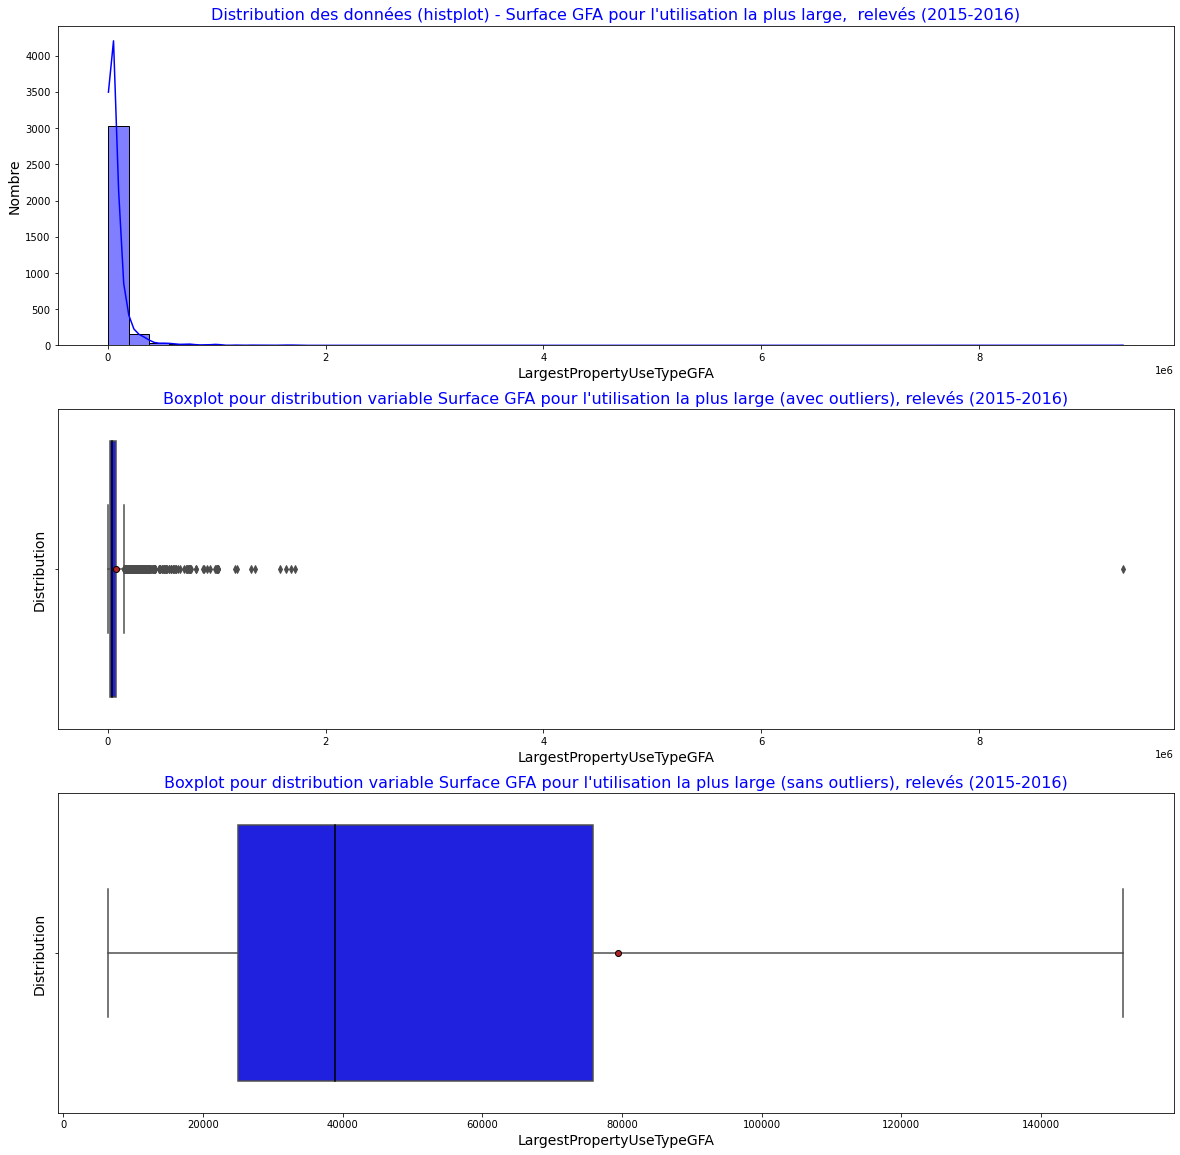

In [89]:
affich_histplot_boxplot(df_data_bat_final, 'LargestPropertyUseTypeGFA', 
                        'Distribution des données (histplot) - Surface GFA pour l\'utilisation la plus large,  relevés (2015-2016)',
                        'Boxplot pour distribution variable Surface GFA pour l\'utilisation la plus large (avec outliers), relevés (2015-2016)',
                        'Boxplot pour distribution variable Surface GFA pour l\'utilisation la plus large (sans outliers), relevés (2015-2016)',50)

#### 5.3.4 Surface GFA pour la 2ème utilisation des bâtiments

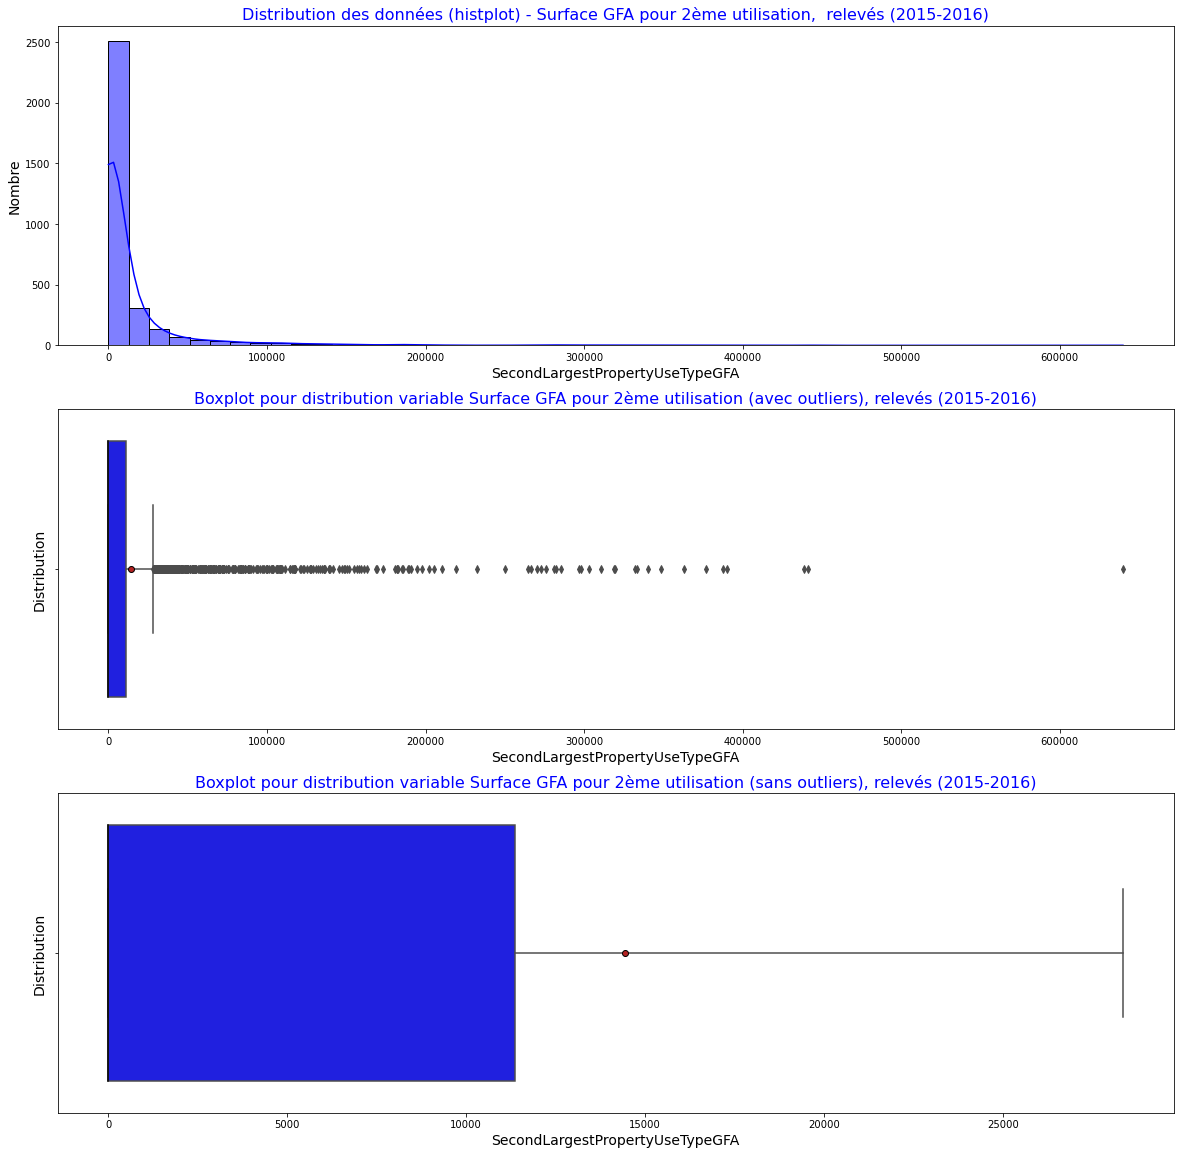

In [90]:
affich_histplot_boxplot(df_data_bat_final, 'SecondLargestPropertyUseTypeGFA', 
                        'Distribution des données (histplot) - Surface GFA pour 2ème utilisation,  relevés (2015-2016)',
                        'Boxplot pour distribution variable Surface GFA pour 2ème utilisation (avec outliers), relevés (2015-2016)',
                        'Boxplot pour distribution variable Surface GFA pour 2ème utilisation (sans outliers), relevés (2015-2016)',50)

#### 5.3.5 Surface GFA pour la 3ème utilisation des bâtiments

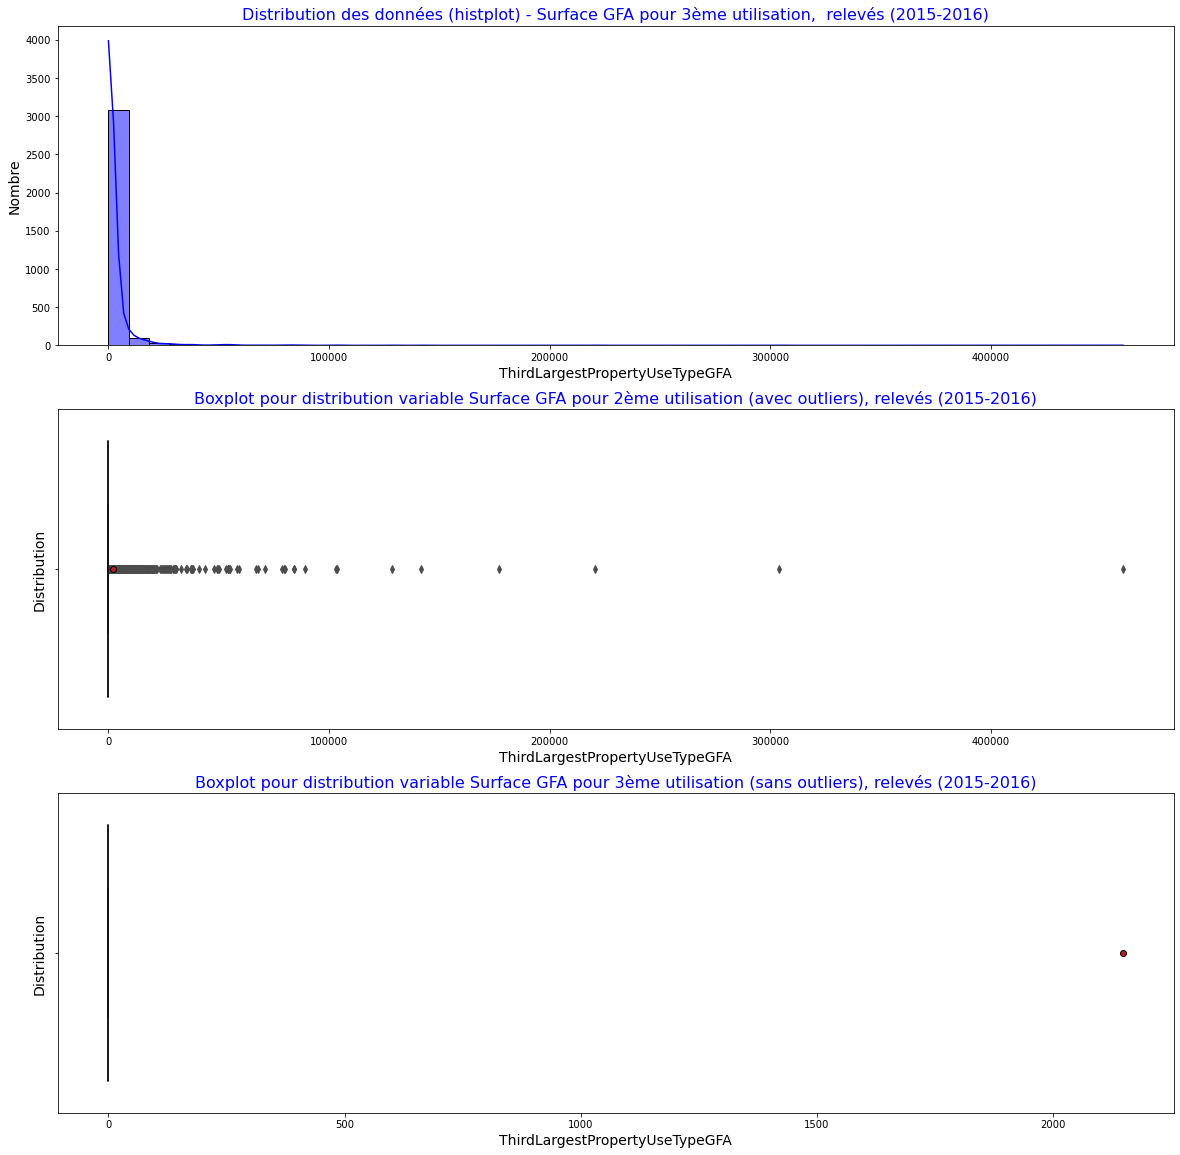

In [91]:
affich_histplot_boxplot(df_data_bat_final, 'ThirdLargestPropertyUseTypeGFA', 
                        'Distribution des données (histplot) - Surface GFA pour 3ème utilisation,  relevés (2015-2016)',
                        'Boxplot pour distribution variable Surface GFA pour 2ème utilisation (avec outliers), relevés (2015-2016)',
                        'Boxplot pour distribution variable Surface GFA pour 3ème utilisation (sans outliers), relevés (2015-2016)',50)

Pour les variables sur l'utilisation les plus répandues des bâtiments en GFA, on remarque aussi que les distributions de données ne suivent pas une distribution normale, mais asymétrique avec beaucoup de valeurs faibles.

#### 5.3.6 Nombre total d'usages du bâtiment

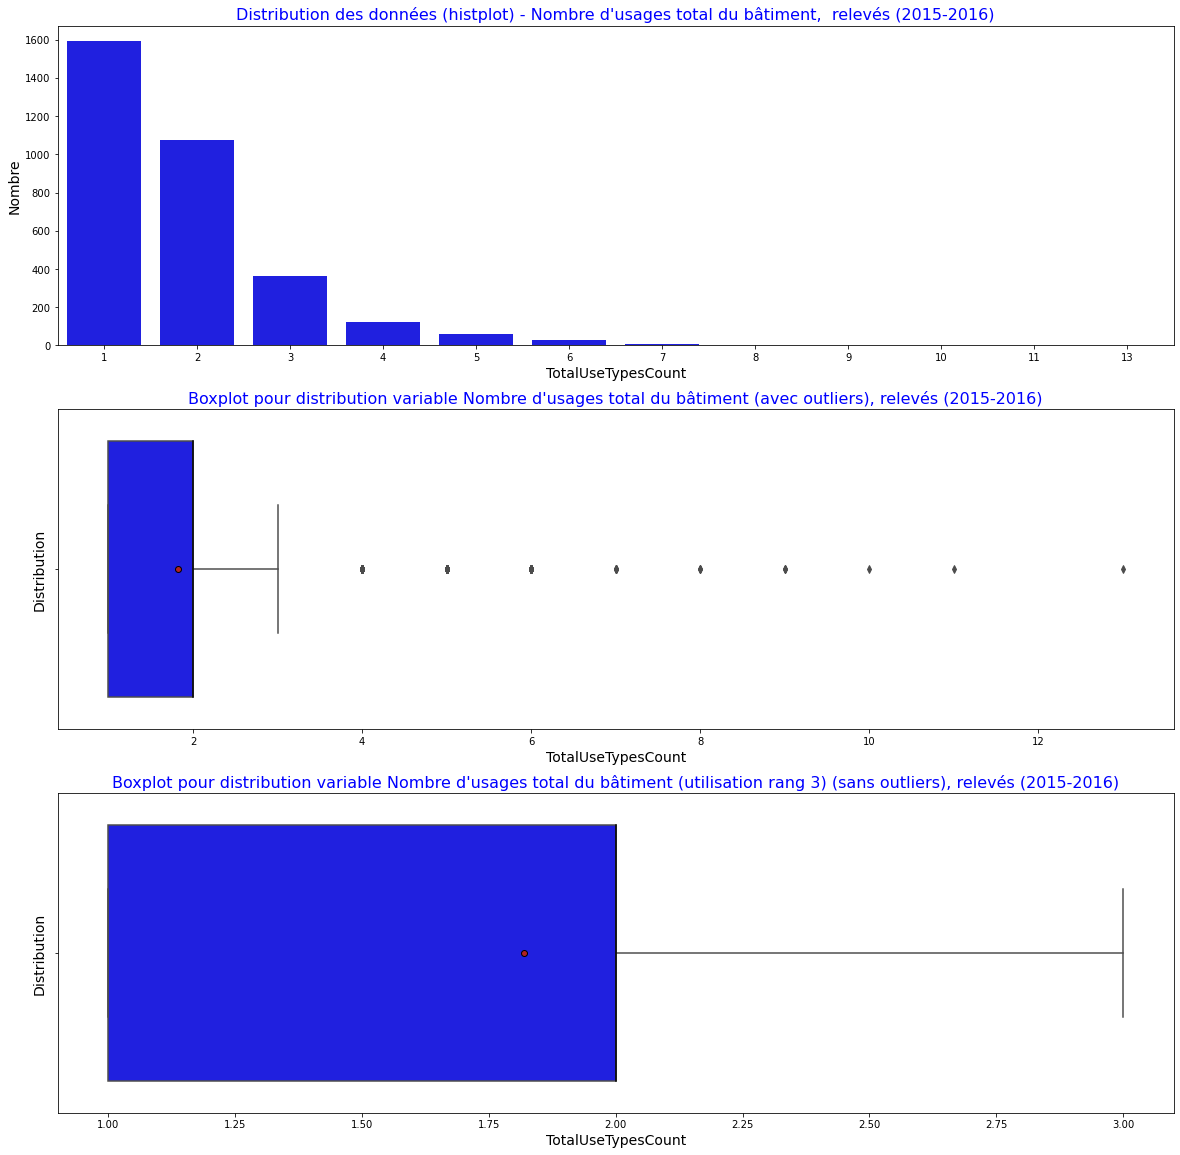

In [92]:
affich_countplot_boxplot(df_data_bat_final, 'TotalUseTypesCount', 
'Distribution des données (histplot) - Nombre d\'usages total du bâtiment,  relevés (2015-2016)',
'Boxplot pour distribution variable Nombre d\'usages total du bâtiment (avec outliers), relevés (2015-2016)',
'Boxplot pour distribution variable Nombre d\'usages total du bâtiment (utilisation rang 3) (sans outliers), relevés (2015-2016)')

#### 5.3.7 Age des bâtiments

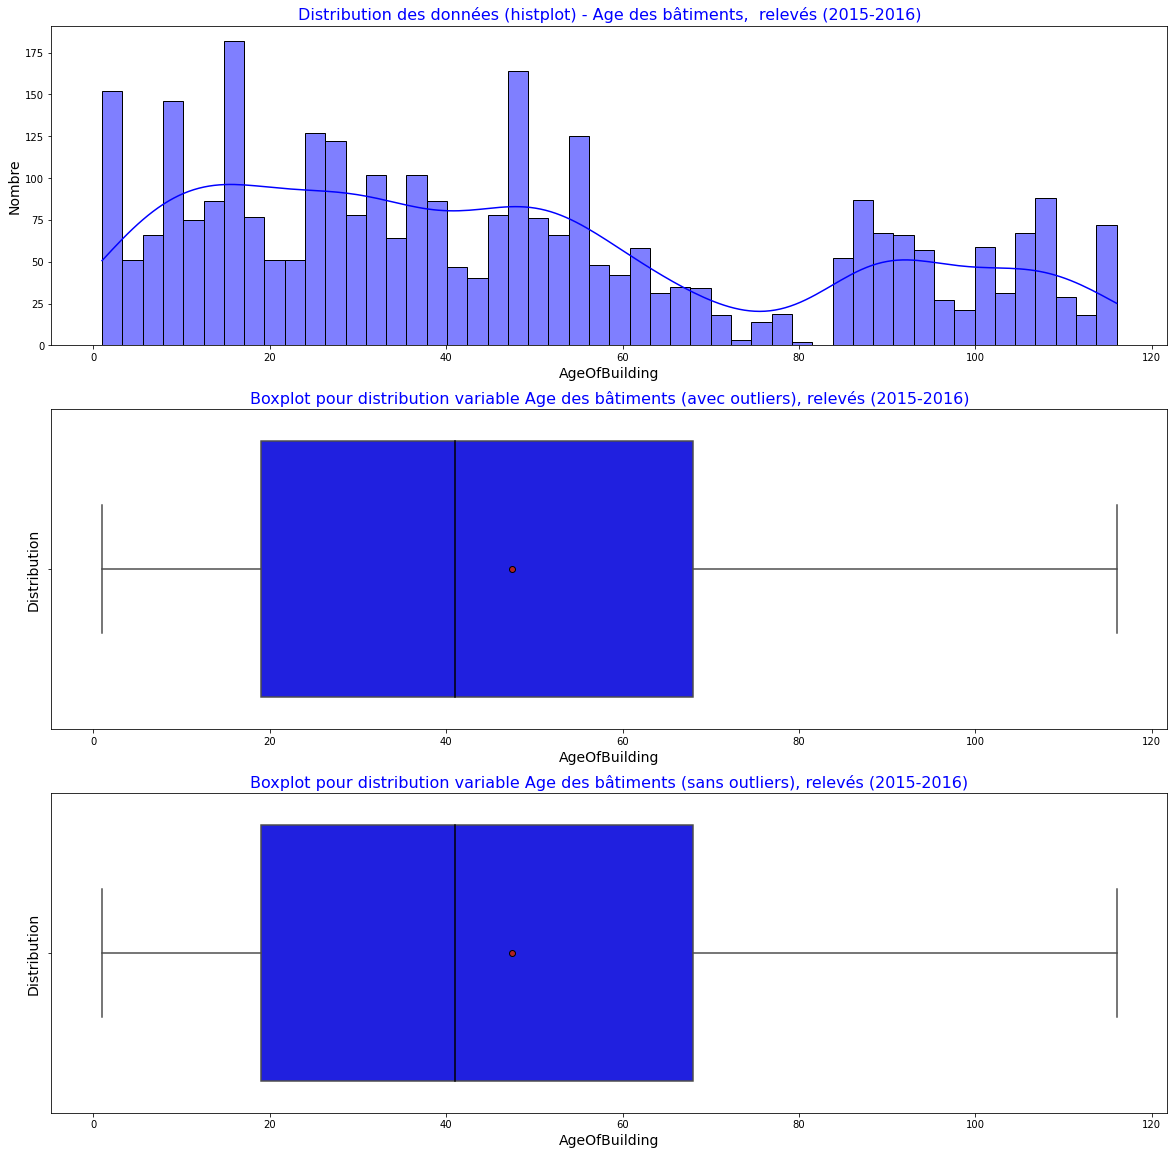

In [93]:
affich_histplot_boxplot(df_data_bat_final, 'AgeOfBuilding', 
                        'Distribution des données (histplot) - Age des bâtiments,  relevés (2015-2016)',
                        'Boxplot pour distribution variable Age des bâtiments (avec outliers), relevés (2015-2016)',
                        'Boxplot pour distribution variable Age des bâtiments (sans outliers), relevés (2015-2016)',50)

#### 5.3.8 Score Energy Star

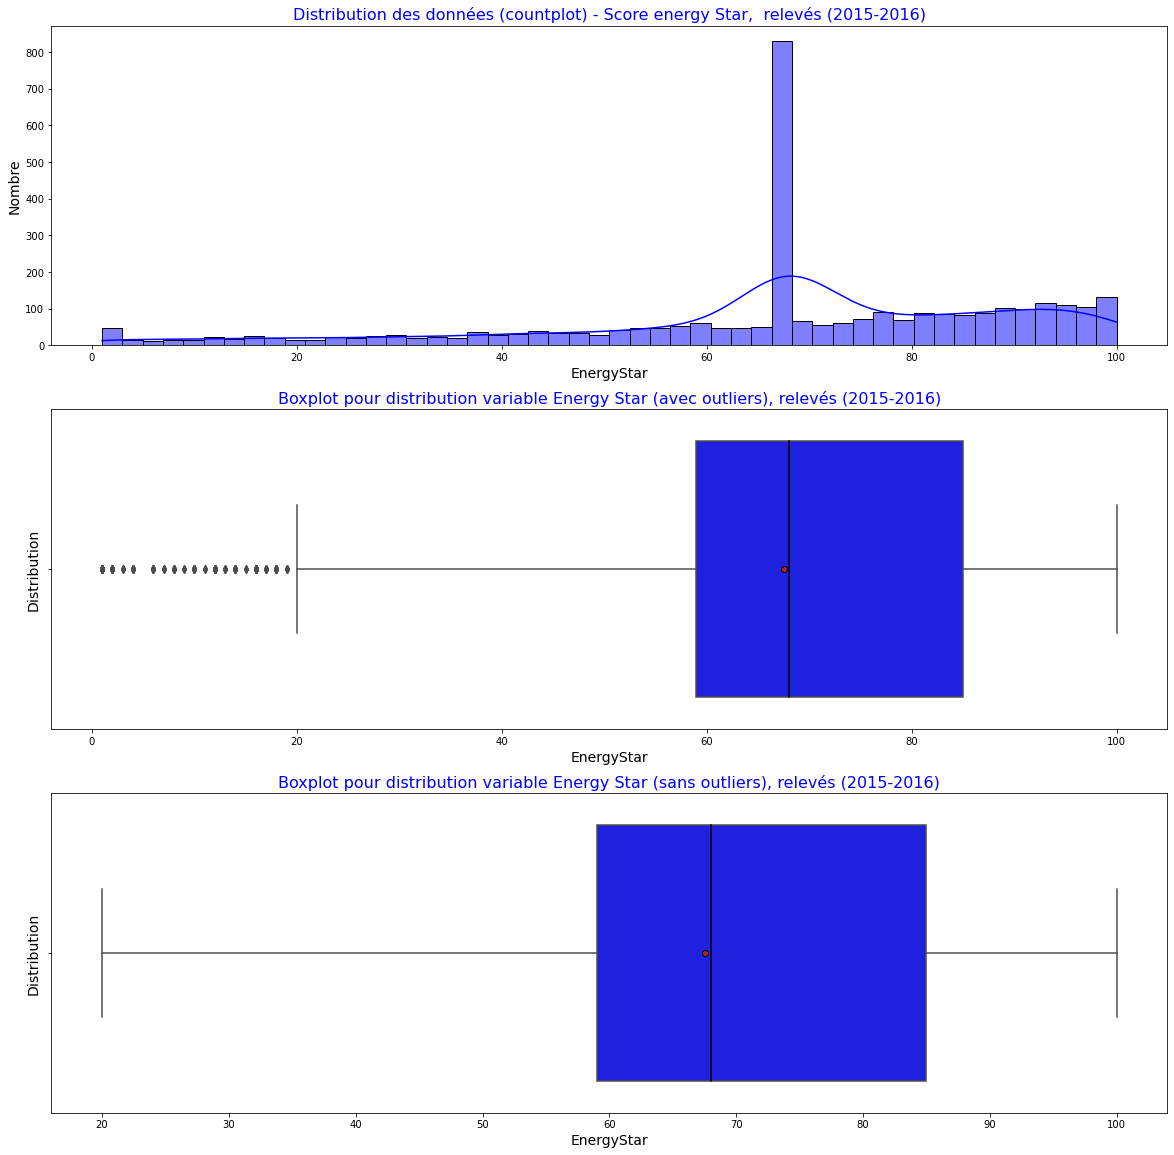

In [94]:
affich_histplot_boxplot(df_data_bat_final, 'EnergyStar', 
                        'Distribution des données (countplot) - Score energy Star,  relevés (2015-2016)',
                        'Boxplot pour distribution variable Energy Star (avec outliers), relevés (2015-2016)',
                        'Boxplot pour distribution variable Energy Star (sans outliers), relevés (2015-2016)',50)

### 5.4 Analyse multivariée des variables

#### 5.4.1 Matrice des corrélations

In [95]:
df_data_bat_final.columns

Index(['Building_id', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions_CO2',
       'GHGEmissionsIntensity_CO2', 'TotalUseTypesCount', 'AgeOfBuilding',
       'Distance_harversine', 'EnergyStar', 'BuildingType',
       'PrimaryPropertyType', 'PropertyName', 'Address', 'Neighborhood',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType'],
      dtype='object')

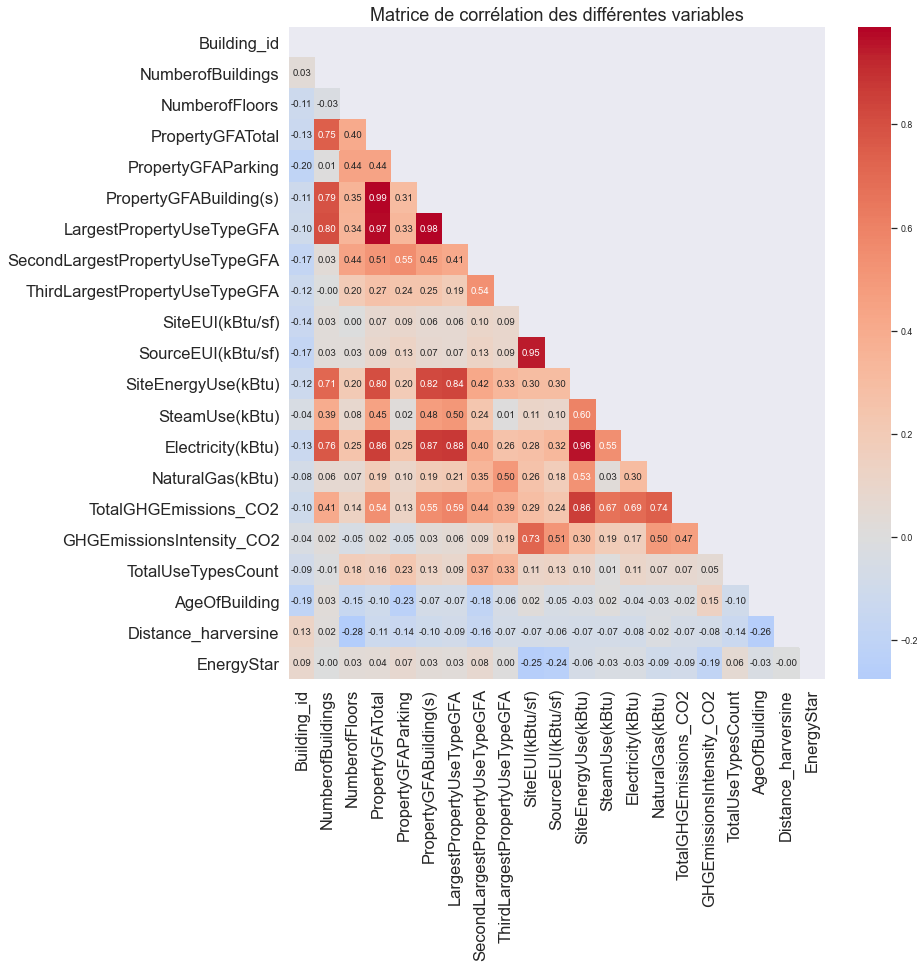

In [96]:
# Sélection des variables numériques du dataset
df_data_bat_final_num = df_data_bat_final.select_dtypes(include='number')

# Calcul et affichage matrice de corrélation
corr_matrix = df_data_bat_final_num.corr()

masque = np.zeros_like(corr_matrix)
masque[np.triu_indices_from(masque)] = True

fig = plt.figure(1, figsize=(12,12))
sns.set(font_scale=1.5)
plt.title('Matrice de corrélation des différentes variables')
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", mask=masque, fmt=".2f", center=0)
plt.show()

In [97]:
df_data_bat_final_num.columns

Index(['Building_id', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions_CO2',
       'GHGEmissionsIntensity_CO2', 'TotalUseTypesCount', 'AgeOfBuilding',
       'Distance_harversine', 'EnergyStar'],
      dtype='object')

Pour les variables à prédire "TotalGHGEmissions_CO2" et "SiteEnergyUse(kBtu)", on remarque tout d'abord une corrélation forte entre les 2 variables à prédire (corr = 0,86), et aussi peu ou pas de corrélation avec la variable représentant la score Energy Star (faible corr négative).

Pour les variables à prédire TotalGHGEmissions et SiteEnergyUse(kBtu), on remarque des corrélations linéaires quasi similaires avec les variables de relevés (les consommations) mais également avec le nombre de batiments ou d'étages ains que les surfaces au sol.

Ensuite, si on regarde plus en détail la variable "TotalGHGEmissions_CO2", on remarque que cette variable est corrélée aux relevés de consommation pour variables "SteamUse(kBtu)" (corr = 0,67), "Electricity(kBtu)" (corr = 0,69) et "NaturalGas(kBtu)" (corr = 0,74), et dans une moindre mesure, aux surfaces aux sols (corr autour de 0,6) pour les variables des surfaces au sol suffixées avec GFA (variables "LargestPropertyUseTypeGFA" et "PropertyGFATotal").

Ensuite, si on regarde plus en détail la variable "SiteEnergyUse(kBtu)", on remarque que cette variable est corrélée fortement aux relevés de consommation pour les variables "Electricity(kBtu)" (corr = 0,96) et dans une moindre mesure au variables "SteamUse(kBtu)" (corr = 0,6) et "NaturalGas" (corr = 0,51), mais surtout aux surfaces aux sols (corr autour de 0,8) pour les variables des surfaces au sol suffixées avec GFA (variables "LargestPropertyUseTypeGFA" (corr = 0,85) et "PropertyGFATotal" (corr = 0,81)) .

Du côté des nouvelles variables, la variable "AgeOfBuilding" semble ne pas être corrélée à d'autres variables ,la variable "TotalUseTypesCount" est faiblement corrélée aux variables GFA (corr autour de 0,3).Enfin, les variables "AreaBuildingsMean" et "AreaParkingMean" sont faiblement corrélées aux variables GFA (corr de 0,2 à 0,53) et les variables "AreaBuildingsMean" et "AreaParkingMean" sont corrélées à hauteur de 0,5. 

On va afficher à présent dans un tableau les variables présentant les plus fortes corrélations linéaires entre elles. On sélectionne donc les paires de variables avec des corrélations de Pearson supérieurs à 0.7

In [98]:
# Affichage des corrélations les plus fortes entre les variables dans la matrice de corrélation 
seuil = 0.7
corr_pairs = corr_matrix.unstack().sort_values(kind="quicksort")
high_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > seuil)])
               .reset_index().rename(columns={0:'corr_coeff'}))
high_corr = high_corr[(high_corr.index%2 == 0) & (high_corr['level_0'] != high_corr['level_1'])]
high_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
36,PropertyGFABuilding(s),PropertyGFATotal,0.989430
34,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,0.979963
32,PropertyGFATotal,LargestPropertyUseTypeGFA,0.974730
30,Electricity(kBtu),SiteEnergyUse(kBtu),0.957103
28,SourceEUI(kBtu/sf),SiteEUI(kBtu/sf),0.948544
26,LargestPropertyUseTypeGFA,Electricity(kBtu),0.878747
24,Electricity(kBtu),PropertyGFABuilding(s),0.870196
22,SiteEnergyUse(kBtu),TotalGHGEmissions_CO2,0.864892
20,PropertyGFATotal,Electricity(kBtu),0.857645
18,LargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),0.840358


On remarque que les variables suffixées GFA présentent de fortes corrélations avec plusieurs autres variables. Nous allons donc créer de nouvelles variables pour tenter de gommer ces corrélations linéaires.


Par ailleurs, on va calculer le VIF (facteur d'inflation de la variance) entre les variables GFA, variables en entrée (prédicteurs), pour voir la multicolinéarité entre variables explicatives.

#### 4.6.3 Feature engineering: création d'une variable pour la surface réelle moyenne par bâtiment

In [99]:
# Calcul de la surface moyenne réelle par bâtiment
# On crée une variable nombre d'étages qui est le nombre de niveaux + le rez de chaussée
df_data_bat_final["Nb_etages"] = 1
df_data_bat_final["Nb_etages"] = df_data_bat_final["NumberofFloors"] + df_data_bat_final["Nb_etages"]
    
# On calcule la surface réelle d'un bâtiment
df_data_bat_final["AreaBuildings"] = df_data_bat_final["Nb_etages"] * df_data_bat_final["PropertyGFABuilding(s)"]
    
# On calcule à présent la surface réelle moyenne par bâtiment
df_data_bat_final["AreaBuildingsMean"] = df_data_bat_final["AreaBuildings"] / df_data_bat_final["NumberofBuildings"]
    
#On supprime les colonnes inutiles à présent
df_data_bat_final.drop(columns=["PropertyGFABuilding(s)","Nb_etages","AreaBuildings"], 
                              axis=1, inplace=True)

#### 4.6.4 Feature engineering: création d'une variable pour la surface moyenne de parking par bâtiment

In [100]:
# Calcul de la surface moyenne de parking par bâtiment
df_data_bat_final["AreaParkingMean"] = df_data_bat_final["PropertyGFAParking"] / df_data_bat_final["NumberofBuildings"]

# On supprime les colonnes inutiles à présent
df_data_bat_final.drop(columns=["PropertyGFAParking"], axis=1, inplace=True)
        

Les données sont à présent bien complétées. Nous allons recalculer la matrice de corrélation et afficher de nouveau les corrélations le plus fortes dans un tableau.

#### 5.4.3 Matrice des corrélations après création des nouvelles variables

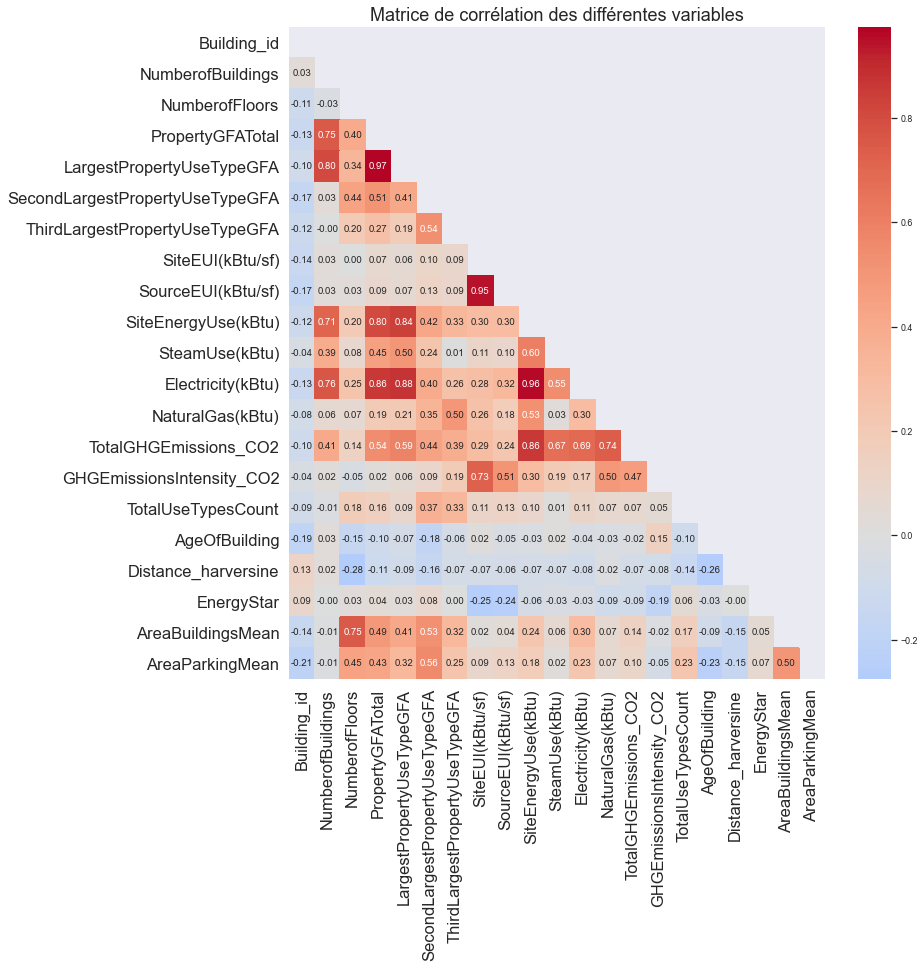

In [101]:
# Sélection des variables numériques du dataset
df_data_bat_final_num = df_data_bat_final.select_dtypes(include='number')

# Calcul et affichage matrice de corrélation
corr_matrix = df_data_bat_final_num.corr()

masque = np.zeros_like(corr_matrix)
masque[np.triu_indices_from(masque)] = True

fig = plt.figure(1, figsize=(12,12))
sns.set(font_scale=1.5)
plt.title('Matrice de corrélation des différentes variables')
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", mask=masque, fmt=".2f", center=0)
plt.show()

In [102]:
# Affichage des corrélations les plus fortes entre les variables dans la matrice de corrélation 
seuil = 0.7
corr_pairs = corr_matrix.unstack().sort_values(kind="quicksort")
high_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > seuil)])
               .reset_index().rename(columns={0:'corr_coeff'}))
high_corr = high_corr[(high_corr.index%2 == 0) & (high_corr['level_0'] != high_corr['level_1'])]
high_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
28,LargestPropertyUseTypeGFA,PropertyGFATotal,0.974730
26,SiteEnergyUse(kBtu),Electricity(kBtu),0.957103
24,SourceEUI(kBtu/sf),SiteEUI(kBtu/sf),0.948544
22,Electricity(kBtu),LargestPropertyUseTypeGFA,0.878747
20,SiteEnergyUse(kBtu),TotalGHGEmissions_CO2,0.864892
18,Electricity(kBtu),PropertyGFATotal,0.857645
16,SiteEnergyUse(kBtu),LargestPropertyUseTypeGFA,0.840358
14,PropertyGFATotal,SiteEnergyUse(kBtu),0.804991
12,NumberofBuildings,LargestPropertyUseTypeGFA,0.803947
10,Electricity(kBtu),NumberofBuildings,0.763847


In [103]:
# Suppression des variables "SourceEUI(kBtu/sf)" et "SiteEUI(kBtu/sf)" exprimés en surface au plancher
df_data_bat_final.drop(columns=['SourceEUI(kBtu/sf)', 'SiteEUI(kBtu/sf)'], inplace=True)

#### 5.4.6 Calcul du VIF (Facteur d'inflation de la variance)

In [104]:
# Calcul VIF entre variables
X_variables = df_data_bat_final_num
vif_data = pd.DataFrame() 
vif_data["Fonctionnalité"] = X_variables.columns 
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data[vif_data['VIF'] > 10].sort_values(by=['VIF'],ascending=False)

,Fonctionnalité,VIF
13,TotalGHGEmissions_CO2,6.724149e+10
12,NaturalGas(kBtu),2.982921e+10
10,SteamUse(kBtu),1.936154e+10
11,Electricity(kBtu),2.528005e+09
9,SiteEnergyUse(kBtu),9.270662e+02
7,SiteEUI(kBtu/sf),1.305110e+02
8,SourceEUI(kBtu/sf),8.443220e+01
3,PropertyGFATotal,5.879824e+01
4,LargestPropertyUseTypeGFA,5.682770e+01
14,GHGEmissionsIntensity_CO2,1.525701e+01


Il ne subsiste que des corrélations importantes entre les variables à prédire.

In [105]:
# Appel de la fonction pour construire la dataframe récapitulant les données disponibles dans le dataset des bâtiments
df_bat_data_dispo = desc_data_dispo(df_data_bat_final_num)
df_bat_data_dispo

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,AreaBuildingsMean,AreaParkingMean
nbre valeurs manquantes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nbre de valeurs dispo.,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259
taux remplissage,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100


In [106]:
df_data_bat_final.reset_index(drop=True, inplace=True)

In [107]:
df_data_bat_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Building_id                      3259 non-null   int64  
 1   NumberofBuildings                3259 non-null   float64
 2   NumberofFloors                   3259 non-null   float64
 3   PropertyGFATotal                 3259 non-null   float64
 4   LargestPropertyUseTypeGFA        3259 non-null   float64
 5   SecondLargestPropertyUseTypeGFA  3259 non-null   float64
 6   ThirdLargestPropertyUseTypeGFA   3259 non-null   float64
 7   SiteEnergyUse(kBtu)              3259 non-null   float64
 8   SteamUse(kBtu)                   3259 non-null   float64
 9   Electricity(kBtu)                3259 non-null   float64
 10  NaturalGas(kBtu)                 3259 non-null   float64
 11  TotalGHGEmissions_CO2            3259 non-null   float64
 12  GHGEmissionsIntensit

## 6. Automatisation nettoyage des données / features engineering

In [108]:
# Répertoire des fichiers CSV
data_rep= './input/'
data_file_2015 = '2015-building-energy-benchmarking.csv'
data_file_2016 = '2016-building-energy-benchmarking.csv'
data_2015 = data_rep + data_file_2015
data_2016 = data_rep + data_file_2016

In [109]:
def automatic_cleaning_features_engine_data(data_2015, data_2016):
    
    # Chargement des relevés 2015 et 2016
    df_bat_2015 = pd.read_csv('./input/2015-building-energy-benchmarking.csv', delimiter=',',
                              encoding='utf-8', low_memory=False)
    df_bat_2016 = pd.read_csv('./input/2016-building-energy-benchmarking.csv', delimiter=',', 
                              encoding='utf-8', low_memory=False)
    
    print('------ Jeu des données relevés 2015 ------')
    print_proportion_nan(df_bat_2015)
    
    print('------ Jeu des données relevés 2016 ------')
    print_proportion_nan(df_bat_2016)
    
    # Uniformisation des données de relevés 2015 et 2016
    # Etape 1 : uniformisation des données de localisation entre 2015 et 2016
    df_bat_2015 = extract_location_2015(df_bat_2015,'Location')
    print('------ Jeu des données relevés 2015 suite uniformisation données Location ------')
    print_proportion_nan(df_bat_2015)
    
    # Etape 2: renommage des variables des relevés 2015 et 2016
    # Relevés 2015
    df_bat_2015 = df_bat_2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"TotalGHGEmissions_CO2",\
                                          "GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity_CO2",\
                                          "Comment":"Comments",\
                                          "latitude":"Latitude",\
                                          "longitude":"Longitude",\
                                          "city":"City",\
                                          "state":"State",\
                                          "zip":"ZipCode",\
                                          "address":"Address",\
                                          "OSEBuildingID":"Building_id"})

    # Relevés 2016 
    df_bat_2016 = df_bat_2016.rename(columns={"TotalGHGEmissions":"TotalGHGEmissions_CO2",\
                                          "GHGEmissionsIntensity":"GHGEmissionsIntensity_CO2",\
                                          "OSEBuildingID":"Building_id"})
    
    
    print('------ Jeu des données relevés 2015 suite renommage des variables ------')
    print_proportion_nan(df_bat_2015)
    
    print('------ Jeu des données relevés 2016 suite renommage des variables ------')
    print_proportion_nan(df_bat_2016)
    
    # Constitution du jeu de données
    # Etape 3: suppression des colonnes du relevé 2015 non présentes en 2016
    df_bat_2015.drop(['OtherFuelUse(kBtu)','2010 Census Tracts',
                'Seattle Police Department Micro Community Policing Plan Areas',
                'City Council Districts','SPD Beats', 'Zip Codes'], axis=1, inplace=True)
    
    print('------ Jeu des données relevés 2015 suite suppression colonnes relevés 2015 non présentes en 2016 ------')
    print_proportion_nan(df_bat_2015)
    
    # Etape 4: concaténation du jeu de données 2015 et 2016
    df_data_bat = pd.concat([df_bat_2015[df_bat_2016.columns],df_bat_2016], axis = 0).sort_values(["DataYear",\
                                                                                                   "Building_id"])
    print('------ Jeu de données suite concaténation des relevés 2015 et 2016 -----')
    print_proportion_nan(df_data_bat)
    
    # Etape 5: suppression des bâtiments destinés à l'habitation
#     df_data_bat = df_data_bat[~df_data_bat['BuildingType'].str.contains("Multifamily")]
    
#     print('------ Jeu de données suite suppression des bâtiments destinés à l\'habitation -----')
#     print_proportion_nan(df_data_bat)
    
    # Etape 6: suppression des bâtiments en doublons entre 2015 et 2016 
    # (moyenne sur les 2 années en gardant dernier relevé)
    col_moyenne = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
                'PropertyGFAParking', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
                'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
                'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
                'NaturalGas(kBtu)', 'TotalGHGEmissions_CO2', 'GHGEmissionsIntensity_CO2']

    id_building_moyenne = df_data_bat[['Building_id']+col_moyenne].groupby('Building_id').mean()
    
    # Suppression des doublons dans le dataset en ne gardant que le dernier relevé
    bat_doublons = df_data_bat.drop_duplicates(subset=['Building_id'], keep='last')
    bat_doublons.drop(col_moyenne, axis=1, inplace=True)

    # Merge des identifiants de bâtiment avec les moyennes des relevés par bâtiment
    df_data_bat = pd.merge(bat_doublons, id_building_moyenne, how='left', on='Building_id')
    
    print('------ Jeu de données suite suppression des bâtiments en doublons -----')
    print_proportion_nan(df_data_bat)
    
    # Etape 7: suppression des variables relevés redondantes
    col_redondante = ['NaturalGas(therms)','Electricity(kWh)']
    df_data_bat.drop(col_redondante, axis=1, inplace=True)
    
    print('------ Jeu de données suite suppression des variables relevés redondantes -----')
    print_proportion_nan(df_data_bat)
    
    # Etape 8: suppression de variables normalisées par rapport aux conditions météorologiques
    df_data_bat.drop(cherche_motif_col_df(df_data_bat,'WN'), axis=1, inplace=True)
    
    print('------ Jeu de données suite suppression des variables normalisées par rapport à la météo -----')
    print_proportion_nan(df_data_bat)
    
    # Etape 9: suppression des variables qualitatives inutiles à la modélisation
    # Appel de la fonction de suppression des variables qualitatives inutiles pour la modélisation
    liste_col_obj_a_supprimer = ['City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber',\
                            'YearsENERGYSTARCertified', 'DefaultData']
    df_data_bat = drop_col_obj_inutile(df_data_bat, liste_col_obj_a_supprimer)
    
    print('------ Jeu de données suite suppression des variables qualitatives inutiles à la modélisation -----')
    print_proportion_nan(df_data_bat)
    
    # Etape 10: suppression des variables quantitatives inutiles à la modélisation
    # Appel de la fonction de suppression des variables quantitatives inutiles pour la modélisation
    liste_col_num_a_supprimer = ['CouncilDistrictCode']
    df_data_bat = drop_col_obj_inutile(df_data_bat, liste_col_num_a_supprimer)
    
    print('------ Jeu de données suite suppression des variables quantitatives inutiles à la modélisation -----')
    print_proportion_nan(df_data_bat)
    
    # Pour la variable "PrimaryPropertyType", remplacement de la valeur "Restaurant\n" par "Restaurant"
    df_data_bat['PrimaryPropertyType'] = df_data_bat['PrimaryPropertyType'].replace(['Restaurant\n'],'Restaurant')
    
    # Mise en majuscules des valeurs pour les variables "PropertyName", "Address" et "Neighborhood" 
    df_data_bat['PropertyName'] = df_data_bat['PropertyName'].str.upper()
    df_data_bat['Address'] = df_data_bat['Address'].str.upper()
    df_data_bat['Neighborhood'] = df_data_bat['Neighborhood'].str.upper()
    
    print('------ Jeu de données suite mise en conformité des données -----')
    print_proportion_nan(df_data_bat)
    
    # Features engineering - création de variables
    # Etape 11: calcul du nombre total d'usages par bâtiment à partir de la variable "ListOfAllPropertyUseTypes"
    # Suppression de la variable "ListOfAllPropertyUseTypes"
    df_data_bat['TotalUseTypesCount'] = [str(word).count(",")\
                                          + 1 for word in df_data_bat['ListOfAllPropertyUseTypes'].str.split(',')]
    df_data_bat.drop(columns='ListOfAllPropertyUseTypes', inplace=True)
    
    print('------ Jeu de données suite création de la variable \"TotalUseTypesCount\" -----')
    print_proportion_nan(df_data_bat)
    
    # Etape 12: calcul de l'âge du bâtiment
    # Suppression des variables "DataYear" et "YearBuilt"
    df_data_bat['AgeOfBuilding'] = df_data_bat['DataYear'] - df_data_bat['YearBuilt']
    df_data_bat.drop(columns=['DataYear', 'YearBuilt'], inplace=True)
    
    print('------ Jeu de données suite création de la variable \"AgeofBuilding\" -----')
    print_proportion_nan(df_data_bat)
    
    # Etape 13: calcul de l'âge du bâtiment
    # Calcul de la distance Haversine
    seattle_lat = 47.6062
    seattle_lon = -122.3321

    # Appel fonction distance Haversine
    df_data_bat['Distance_harversine'] = [distance_haversine(seattle_lat, seattle_lon, x, y) 
                              for x, y in zip(df_data_bat.Latitude.astype(float), 
                                              df_data_bat.Longitude.astype(float))]
    
    # On supprime les colonnes "Latitude" et "Longitude"
    df_data_bat.drop(columns=["Latitude","Longitude"], axis=1, inplace=True)
    
    print('------ Jeu de données suite création de la variable "Distance_haversine" -----')
    print_proportion_nan(df_data_bat)
    
    # Traitement des valeurs manquantes (NaN)
    # Etape 14: traitement des variables numériques
    # Traitement valeurs NaN pour les relevés et les variables "LargestUseTypeGFA"
    df_data_bat = traite_nan_num(df_data_bat,'TotalUseTypesCount', 'LargestPropertyUseTypeGFA',\
                                            'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',\
                                            'PropertyGFATotal', 'ENERGYSTARScore')
    
    print('------ Jeu de données suite au traitement des valeurs NaN des variables numériques -----')
    print_proportion_nan(df_data_bat)
    
    # Etape 15: traitement des variables qualitatives
    # Prise en compte des bâtiments avec le statut "Compliant" (conforme)
    df_data_bat = df_data_bat[df_data_bat['ComplianceStatus'] == "Compliant"]
    
    print('------ Jeu de données suite à la prise en compte des bâtiments conformes -----')
    print_proportion_nan(df_data_bat)
    
    # Affectation des listes des colonnes à supprimer, à imputer
    liste_col_a_supprimer = ['Comments', 'ComplianceStatus']
    liste_col_a_imputer = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

    # Appel de la fonction pour le traitement des valeurs manquantes pour les variables qualitatives
    df_data_bat = traite_nan_obj(df_data_bat, liste_col_a_supprimer, liste_col_a_imputer, val_imput='Other')
    
    print('------ Jeu de données suite au traitement des variables qualitatives -----')
    print_proportion_nan(df_data_bat)
    
    # Suppression des bâtiments avec le statut 'Low Outlier' et suppression de la variable "Outlier"
    df_data_bat = df_data_bat[~df_data_bat["Outlier"].isnull()==False]
    df_data_bat.drop('Outlier', axis=1, inplace=True)

    print('')
    print('------- Dataset suite suppression colonne "Outlier"')
    print_proportion_nan(df_data_bat)
    
    # Traitement des outliers
    # Etape 16: suppression des valeurs négatives pour les variables numériques
    df_data_bat.drop(df_data_bat.loc[df_data_bat['PropertyGFAParking']<0].index, inplace=True)
    df_data_bat.drop(df_data_bat.loc[df_data_bat['PropertyGFABuilding(s)']<0].index, inplace=True)

    print('------- Dataset suite traitement des outliers - variables \"AreaBuildingsArea\" et \"AreaParkingMean\"')
    print_proportion_nan(df_data_bat)
    
    # Traitement suite analyse exploratoire des données
    # Etape 17: calcul de la surface moyenne réelle par bâtiment
    # On crée une variable nombre d'étages qui est le nombre de niveaux + le rez de chaussée
    df_data_bat["Nb_etages"] = 1
    df_data_bat["Nb_etages"] = df_data_bat["NumberofFloors"] + df_data_bat["Nb_etages"]
    
    # On calcule la surface réelle d'un bâtiment
    df_data_bat["AreaBuildings"] = df_data_bat["Nb_etages"] * df_data_bat["PropertyGFABuilding(s)"]
    
    # On calcule à présent la surface réelle moyenne par bâtiment
    df_data_bat["AreaBuildingsMean"] = df_data_bat["AreaBuildings"] / df_data_bat["NumberofBuildings"]
    
    #On supprime les colonnes inutiles à présent
    df_data_bat.drop(columns=["PropertyGFABuilding(s)", "AreaBuildings", "Nb_etages"], 
                              axis=1, inplace=True)
    
    print('------ Jeu de données suite création de la variable \"AreaBuildingsMean\" -----')
    print_proportion_nan(df_data_bat)
    
    # Etape 18: calcul de la surface moyenne de parking par bâtiment
    df_data_bat["AreaParkingMean"] = df_data_bat["PropertyGFAParking"] / df_data_bat["NumberofBuildings"]
    df_data_bat.drop(columns=["PropertyGFAParking"], axis=1, inplace=True)
    
    print('------ Jeu de données suite création de la variable \"AreaParkingMean\" -----')
    print_proportion_nan(df_data_bat)
    
    # Etape 19: suppression des variables d'entrée avec multicolinéarité et variables GFA
    df_data_bat.drop(columns=['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)'], inplace=True)

    print('----- Jeu de données suite suppression variables avec multicolinéarité ------')
    print_proportion_nan(df_data_bat)

    
    return df_data_bat

In [110]:
df_data_bat_final = automatic_cleaning_features_engine_data(data_2015, data_2016)

------ Jeu des données relevés 2015 ------
Proportion de NaN : 16.89 %, Taille du jeu de données : (3340, 47)

------ Jeu des données relevés 2016 ------
Proportion de NaN : 12.85 %, Taille du jeu de données : (3376, 46)

------ Jeu des données relevés 2015 suite uniformisation données Location ------
Proportion de NaN : 15.26 %, Taille du jeu de données : (3340, 52)

------ Jeu des données relevés 2015 suite renommage des variables ------
Proportion de NaN : 15.26 %, Taille du jeu de données : (3340, 52)

------ Jeu des données relevés 2016 suite renommage des variables ------
Proportion de NaN : 12.85 %, Taille du jeu de données : (3376, 46)

------ Jeu des données relevés 2015 suite suppression colonnes relevés 2015 non présentes en 2016 ------
Proportion de NaN : 13.18 %, Taille du jeu de données : (3340, 46)

------ Jeu de données suite concaténation des relevés 2015 et 2016 -----
Proportion de NaN : 13.01 %, Taille du jeu de données : (6716, 46)

------ Jeu de données suite suppr

In [111]:
df_data_bat_final

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,AreaBuildingsMean,AreaParkingMean
0,61,1.0,4.0,48383.0,38172.0,10211.0,0.0,2.953338e+06,915977.0,1.448859e+06,5.885630e+05,112.06,2.19,2,115,0.456414,75.0,Multifamily LR (1-4),Low-Rise Multifamily,GATEWOOD APTS,107 PINE ST,DOWNTOWN,Multifamily Housing,Retail Store,Other,241915.0,0.0
1,266,1.0,4.0,52134.0,52134.0,0.0,0.0,1.212551e+06,0.0,1.212601e+06,0.000000e+00,8.45,0.06,1,8,4.745164,85.0,Multifamily LR (1-4),Low-Rise Multifamily,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE,Multifamily Housing,Other,Other,260670.0,0.0
2,325,1.0,4.0,111077.0,111077.0,0.0,0.0,9.898724e+06,0.0,9.899135e+06,0.000000e+00,69.01,0.24,1,26,0.439292,91.0,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN,Other,Other,Other,555385.0,0.0
3,400,1.0,6.0,98370.0,98370.0,0.0,0.0,6.525887e+06,0.0,6.488262e+06,3.789300e+04,47.24,0.20,1,109,0.236408,45.0,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN,Office,Other,Other,507150.0,25920.0
4,442,1.0,4.0,193788.0,138672.0,47539.0,11166.0,1.676022e+07,0.0,1.676091e+07,0.000000e+00,116.84,0.23,5,68,1.171413,59.0,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION,Office,Parking,Other,779670.0,37854.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3426,50221,1.0,1.0,18261.0,18261.0,0.0,0.0,9.320821e+05,0.0,6.323620e+05,2.997200e+05,20.33,1.11,1,34,4.935141,68.0,Nonresidential COS,Other,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS,Other - Recreation,Other,Other,36522.0,0.0
3428,50223,1.0,1.0,16000.0,16000.0,0.0,0.0,9.502762e+05,0.0,3.965461e+05,5.537300e+05,32.17,2.01,1,12,0.811312,68.0,Nonresidential COS,Other,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN,Other - Recreation,Other,Other,32000.0,0.0
3429,50224,1.0,1.0,13157.0,7583.0,5574.0,0.0,5.765898e+06,0.0,1.792159e+06,3.973739e+06,223.54,16.99,3,42,2.407156,68.0,Nonresidential COS,Other,QUEEN ANNE POOL,1920 1ST AVE W,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,26314.0,0.0
3430,50225,1.0,1.0,14101.0,6601.0,6501.0,484.0,7.194712e+05,0.0,3.488702e+05,3.706010e+05,22.11,1.57,5,27,5.389475,68.0,Nonresidential COS,Mixed Use Property,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,28202.0,0.0


In [112]:
df_data_bat_final.reset_index(drop=True, inplace=True)

In [113]:
df_data_bat_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Building_id                      3259 non-null   int64  
 1   NumberofBuildings                3259 non-null   float64
 2   NumberofFloors                   3259 non-null   float64
 3   PropertyGFATotal                 3259 non-null   float64
 4   LargestPropertyUseTypeGFA        3259 non-null   float64
 5   SecondLargestPropertyUseTypeGFA  3259 non-null   float64
 6   ThirdLargestPropertyUseTypeGFA   3259 non-null   float64
 7   SiteEnergyUse(kBtu)              3259 non-null   float64
 8   SteamUse(kBtu)                   3259 non-null   float64
 9   Electricity(kBtu)                3259 non-null   float64
 10  NaturalGas(kBtu)                 3259 non-null   float64
 11  TotalGHGEmissions_CO2            3259 non-null   float64
 12  GHGEmissionsIntensit

In [114]:
# Appel de la fonction pour construire la dataframe récapitulant les données disponibles dans le dataset des bâtiments
df_bat_data_dispo = desc_data_dispo(df_data_bat_final)
df_bat_data_dispo

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,AreaBuildingsMean,AreaParkingMean
nbre valeurs manquantes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nbre de valeurs dispo.,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259,3259
taux remplissage,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100


In [115]:
# Sauvegarde du dataset final pour modélisation
df_data_bat_final.set_index("Building_id").to_csv("./input/df_data_bat_model.csv")